In [61]:
from astropy.io import fits
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
from pandas.io.formats.style import Styler
from matplotlib.colors import LinearSegmentedColormap
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from joblib import parallel_backend
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
import warnings
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
import seaborn as sns
from matplotlib.lines import Line2D
import os.path as path
from sklearn.metrics import root_mean_squared_error

# Predicción de edades estelares a partir de abundancias químicas, por medio de técnicas de Machine Learning

## Cristián Scheiding

# Introducción

El propósito de este trabajo es encontrar correlaciones entre parámetros mediante el uso de *Machine Learning* (módulo ``sklearn``). Para lo anterior, se realizan las siguientes etapas:

1. **Importar grandes cantidades de datos de observaciones** de atmósferas estelares realizadas por el *survey* GALAH DR4. Esto incluye **seleccionar los parámetros de interés** y las tuplas de datos (estrellas) que cumplan ciertos criterios.

2. Analizar las **distribuciones de los diferentes parámetros y determinar los intervalos de confianza** que permitan eliminar la mayor cantidad posible de *outliers*, si es que los hay.

3. Hacerse una idea de las correlaciones que podrían existir entre los parámetros, por medio de los **coeficientes de correlación no paramétricos de Pearson y Spearman**.

4. **Categorizar las tuplas de datos (estrellas)** según sus velocidades medidas, que son indicativas de la **región galáctica** a la que pertenecen.

5. Introducir la noción de **árbol de decisión**, concepto que será útil para **determinar las correlaciones más significativas entre los parámetros**.

6. Realizar un **Random Forest de clasificación** para cada región galáctica: halo, disco delgado y disco grueso. Esto permitirá encontrar los parámetros más relevantes en la predicción de dicha clasificación.

7. Realizar un **Random Forest de regresión** para determinar los parámetros más relevantes en la predicción de la abundancia química de magnesio $\operatorname{[Mg/Fe]}$ en atmósferas estelares. Como se ha encontrado que el $\operatorname{[Mg/Fe]}$ está correlacionado con la **edad estelar**, esto permite identificar la **distribución de edades de las estrellas según dos componentes: $\operatorname{[Mg/Fe]}$ y el parámetro que lo prediga**.

# Índice
1. [Importación de los datos de estrellas del catálogo GALAH DR4](#1)
2. [Búsqueda y descarte de *outliers*](#2)
3. [Coeficientes de correlación no paramétricos](#3)
4. [Categorización de estrellas de diferentes componentes galácticas: disco delgado, grueso y halo](#4)
5. [Definición de los árboles de decisión](#5)
6. [Árboles de clasificación](#6)
7. [Árboles de regresión](#7)

# 1. Importación de los datos de estrellas del catálogo GALAH DR4 <a id="1"></a>

## 1.a) Cargar catálogos

Se tienen **cuatro catálogos**:
1. Parámetros y abundancias estelares
2. Información de Gaia DR3, 2MASS y WISE
3. Información cinemática y dinámica galácticas
4. Abundancias de Li (3D NLTE)

En principio, solo interesan los **catálogos 1 y 3**.

In [62]:
def cargar_catalogos(numeros: tuple) -> tuple[pd.DataFrame | None]:
    ruta_catalogos = '/Users/cscheiding/Desktop/AST0421/experiencia4/'

    catalogo_1, catalogo_2, catalogo_3, catalogo_4 = None, None, None, None

    if 1 in numeros:
        # Catálogo de parámetros y abundancias estelares:
        archivo_catalogo_1 = 'galah_dr4_allstar_240705.fits'
        with fits.open(ruta_catalogos + archivo_catalogo_1) as data:
            catalogo_1 = pd.DataFrame(data[1].data)

    if 2 in numeros:
        # Catálogo con información de Gaia DR3, 2MASS y WISE:
        archivo_catalogo_2 = 'galah_dr4_vac_wise_tmass_gaiadr3_240705.fits'
        with fits.open(ruta_catalogos + archivo_catalogo_2) as data:
            catalogo_2 = pd.DataFrame(data[1].data)

    if 3 in numeros:
        # Catálogo con información cinemática y dinámica galácticas:
        archivo_catalogo_3 = 'galah_dr4_vac_dynamics_240705.fits'
        with fits.open(ruta_catalogos + archivo_catalogo_3) as data:
            catalogo_3 = pd.DataFrame(data[1].data)

    if 4 in numeros:
        # Catálogo con abundancias de Li (3D NLTE):
        archivo_catalogo_4 = 'galah_dr4_vac_3dnlte_a_li_240705.fits'
        with fits.open(ruta_catalogos + archivo_catalogo_4) as data:
            catalogo_4 = pd.DataFrame(data[1].data)

    # Retornar catálogos:
    return catalogo_1, catalogo_2, catalogo_3, catalogo_4
    

In [63]:
catalogo_1, catalogo_2, catalogo_3, catalogo_4 = cargar_catalogos((1, 3))

In [64]:
print(f'- Catálogo 1: {len(catalogo_1)} estrellas')
# print(f'- Catálogo 2: {len(catalogo_2)} estrellas')
print(f'- Catálogo 3: {len(catalogo_3)} estrellas')
# print(f'- Catálogo 4: {len(catalogo_4)} estrellas')

- Catálogo 1: 917588 estrellas
- Catálogo 3: 917588 estrellas


## 1.b) Seleccionar columnas de interés, juntar catálogos y filtrarlos por *flags* <a id="1b"></a>

La función ``combinar_catalogos`` hace lo siguiente:
1. Filtrar los catálogos 1 y 3 por las columnas de interés
2. Combinarlos por su **GALAH ID** (``sobject-id``), con un **full outer join**. De todas formas, esto último no impacta el resultado, pues ambos catálogos tienen la misma cantidad de estrellas: 917.588.
3. Filtrar el catálogo combinado por los atrtibutos (según su *flag* correspondiente) que recomiendan en el *survey* GALAH (https://www.galah-survey.org/dr4/using_the_data/#recommended-flag-values):

- **Spectroscopic quality flag (``flag_sp``):** Solo considerar estrellas con ``flag_sp == 0``, que indica que **no se encontraron posibles fuentes de error (e.g. falta de datos, baja señal a ruido y malos resultados de análisis) en el cálculo de las propiedades de cada estrella**.

- **$\operatorname{[Fe/H]}$ quality flag (``flag_fe_h``):** Hubo un error en su cálculo en el GALAH DR4, por lo que **no es un indicador significativo de la precisión en el cálculo de $\operatorname{[Fe/H]}$** (``fe_h``).

- **Chemical abundances quality flags (``flag_X_fe``):** Conviene considerar solo la abundancia de un elemento $X$ si ``flag_X_fe == 0``, pues esto indica que **no se detectaron problemas en la determinación de la abundancia elemental de $X$**.

 - **Red camera signal to noise per pixel ``snr_px_ccd3``:** Conviene considerar solo estrellas con ``snr_px_ccd3 > 30`` (señal a ruido por pixel en la cámara roja).

 4. Reemplazar los valores $\pm \infty$ en las columnas por NaNs
 5. Eliminar todas las tuplas que contengan algún NaN.

In [65]:
# Crear modelo que almacene los nombres de las columnas de interés, para cada
# catálogo:
class Modelo:
    def __init__(self, nombre: str, columnas_catalogo_1: tuple[str],
                 columnas_catalogo_3: tuple[str], **kwargs) -> None:
        # Nombre del modelo:
        self.nombre = nombre

        # Columnas de interés:
        self.columnas_catalogo_1 = columnas_catalogo_1
        self.columnas_catalogo_3 = columnas_catalogo_3

        # DataFrame del catálogo combinado:
        self.catalogo_sin_nans = None

        # Columnas del catálogo combinado:
        self.columnas_finales = None
        
        # Actualizar diccionario de la Clase automáticamente:
        self.__dict__.update(kwargs)

    def actualizar_columnas(self) -> None:
        # Actualizar el listado de las columnas en el catálogo combinado:
        self.columnas_finales = list(self.catalogo_sin_nans)

In [66]:
def combinar_catalogos(modelo: Modelo,
                        catalogo_1: pd.DataFrame,
                        catalogo_3: pd.DataFrame) -> pd.DataFrame:
    # Columnas de interés:
    columnas_catalogo_1 = list(modelo.columnas_catalogo_1)
    columnas_catalogo_3 = list(modelo.columnas_catalogo_3)

    # Flags recomendadas por GALAH:
    lista_flags = ['flag_sp', 'snr_px_ccd3']

    # Agregar la columna 'flag_X_fe' correspondiente al elemento 'X_fe', para
    # cada elemento (catálogo 1):
    for columna in columnas_catalogo_1:
        # Formato que siguen las columnas de abundancias químicas: 'X_fe'
        patron = re.compile('^flag_[A-Z][a-z]{0,1}_fe$')

        # Si la columna corresponde a una abundancia química 'X_fe', se agrega
        # la columna 'flag_X_fe':
        if re.fullmatch(patron, columna):
            flag = 'flag' + columna # Flag 'flag_X_fe'
            lista_flags.append(flag)
    
    # Agregar flags a las columnas de interés (catálogo 1):
    columnas_catalogo_1.extend(lista_flags)

    # Nuevos DataFrame de los catálogos originales con las columnas de interés:
    catalogo_1_reducido = catalogo_1[columnas_catalogo_1] # Catálogo 1
    catalogo_3_reducido = catalogo_3[columnas_catalogo_3] # Catálogo 3

    # Combinar los dos catálogos (full outer join) por el GALAH ID de cada
    # estrella:
    catalogo_combinado = pd.merge(catalogo_1_reducido, catalogo_3_reducido,
                                    on = 'sobject_id', how = 'outer')
    
    # Filtrar por las flags recomendadas por GALAH:
    catalogo_flags = catalogo_combinado.copy() # Catálogo después de filtrar

    for columna in columnas_catalogo_1:
        # Patrón que siguen los flags de abundancias químicas: 'flag_X_fe'
        patron = re.compile('^flag_[A-Z][a-z]{0,1}_fe$')

        # Para abundancias químicas, filtrar: 'flag_X_fe == 0'
        if re.fullmatch(patron, columna):
            catalogo_flags = catalogo_flags.loc[catalogo_flags[columna] == 0]
        elif columna == 'flag_sp':
            catalogo_flags = catalogo_flags.loc[catalogo_flags[columna] == 0]
        elif columna == 'snr_px_ccd3':
            catalogo_flags = catalogo_flags.loc[catalogo_flags[columna] > 30]
    
    # Eliminar las columnas de las flags (ya no son necesarias) en el DataFrame
    # resultante:
    catalogo_flags.drop(columns = lista_flags, inplace = True)
    
    # Reemplazar los valores infinito (positivo o negativo) en el DataFrame por
    # NaNs:
    catalogo_inf = catalogo_flags.replace([np.inf, -np.inf], np.nan)

    # Eliminar las filas que tengan NaNs en alguna columna:
    catalogo_sin_nans = catalogo_inf.copy().dropna(axis = 0, how = 'any',
                                                    ignore_index = True)
    
    # Si está dentro del catálogo, eliminar columna 'logg' y reemplazarla por
    # 'g':
    if 'logg' in list(catalogo_sin_nans):
        catalogo_sin_nans['g'] = 10 ** catalogo_sin_nans['logg']
        catalogo_sin_nans.drop(columns = ['logg'], inplace = True)

    # Resetear los índices de las estrellas del catálogo:
    catalogo_sin_nans.reset_index(drop = True, inplace = True)

    # Imprimir el número de estrellas del catálogo resultante:
    print(f'- {modelo.nombre} - Catálogo sin NaNs:',
          f'{len(catalogo_sin_nans)} estrellas')
    
    return catalogo_sin_nans

## 1.c) Definición del primer modelo

El **Modelo 1** corresponderá a la predicción de la región galáctica a la que pertenece una estrella, a partir de sus propiedades medidas:

In [67]:
modelo_1 = Modelo(nombre = 'Modelo 1',
                columnas_catalogo_1 = ('sobject_id', 'teff', 'logg', 'fe_h',
                                        'vmic', 'vsini',
                                        'mass', 'age', 'lbol',
                                        'mg_fe', 'si_fe', 'ca_fe', 'ti_fe',
                                        'c_fe', 'n_fe', 'o_fe',
                                        'na_fe', 'al_fe', 'k_fe',
                                        'sc_fe', 'v_fe', 'cr_fe', 'mn_fe',
                                        'co_fe', 'ni_fe', 'cu_fe', 'zn_fe',
                                        'rb_fe', 'sr_fe', 'y_fe', 'zr_fe',
                                        'mo_fe', 'ba_fe', 'la_fe', 'ce_fe',
                                        'nd_fe',
                                        'ru_fe', 'sm_fe', 'eu_fe'),
                columnas_catalogo_3 = ('sobject_id',
                                       'R_Rzphi', 'z_Rzphi', 'phi_Rzphi',
                                       'vR_Rzphi', 'vz_Rzphi', 'vT_Rzphi',
                                       'zmax'))

In [68]:
# Combinar las columnas de interés en los catálogos 1 y 3:
modelo_1.catalogo_sin_nans = combinar_catalogos(modelo_1, catalogo_1,
                                                catalogo_3)
modelo_1.actualizar_columnas()
modelo_1.catalogo_sin_nans.head(5)

- Modelo 1 - Catálogo sin NaNs: 107007 estrellas


sobject_id         teff      fe_h      vmic     vsini      mass  \
0  140811005001160  4819.867188  0.156381  1.214888  2.498944  1.161967   
1  140708007101236  3904.778076 -0.591996  1.540267  5.611545  0.879937   
2  170713005601298  4117.222656 -0.924026  1.825891  6.079543  1.766875   
3  170910004101289  4366.514160 -0.565017  1.849028  6.531576  1.003146   
4  140711003901358  3907.150635 -1.214588  1.912204  7.582154  0.938070   

         age         lbol     mg_fe     si_fe  ...     sm_fe     eu_fe  \
0   7.264210     9.799262  0.009314  0.027905  ... -0.065947  0.199954   
1  11.899693   349.387787  0.237782  0.463043  ...  0.106381  0.857074   
2   1.470553  1215.825317  0.193886  0.193995  ...  0.308313  0.913392   
3   8.639011   146.775955  0.145063  0.166607  ...  0.230463  0.019208   
4   5.784471  1415.405273  0.341277  0.400490  ...  0.019455  0.025812   

    R_Rzphi   z_Rzphi  phi_Rzphi    vR_Rzphi   vz_Rzphi    vT_Rzphi      zmax  \
0  7.774796 -0.679510  -0.075939   16.278175 -14.997689  246.709259  0.828761   
1  6.667745 -3.257790  -0.502484  -97.376358  32.368900   74.461678  3.607610   
2  6.021331 -6.970664  -0.644948  -67.876999  58.996338   12.196117  7.542087   
3  9.200190 -4.173048   0.315668   60.378155   6.996849   52.205936  4.735855   
4  7.110991 -5.289556  -0.964015 -182.235275  62.525635  -33.526409  8.309965   

             g  
0  1580.648804  
1    14.461854  
2    10.314467  
3    61.368214  
4     3.814959  

[5 rows x 46 columns]

# 2. Búsqueda y descarte de *outliers*

## 2.a) Buscar *outliers*

Se estudian las distribuciones de las columnas de interés:

In [69]:
# Nombres y unidades de las columnas
modelo_1.info_columnas = {
    'teff': (r'Temperatura efectiva $T_{\mathrm{eff}}$', u.K),
    'g': (r'Gravedad superficial $g$', u.cm / (u.s ** 2)),
    'fe_h': (r'$\operatorname{[Fe/H]}$', None),
    'mass': (r'Masa estelar $M$', u.solMass),
    'age': ('Edad estelar', u.Gyr),
    'lbol': (r'Luminosidad bolométrica $L_{\mathrm{bol}}$', u.solLum),
    # 'rv_comp_1': (r'Velocidad radial $v_{R}$', u.km / u.s),
    'R_Rzphi': (r'$R_{\mathrm{GSR}}$', u.kpc),
    'z_Rzphi': (r'$Z_{\mathrm{GSR}}$', u.kpc),
    'phi_Rzphi': (r'$\phi_{\mathrm{GSR}}$', u.rad),
    'vR_Rzphi': (r'Velocidad radial $V_R$', u.km / u.s),
    'vz_Rzphi': (r'Velocidad perpendicular $V_Z$', u.km / u.s),
    'vT_Rzphi': (r'Velocidad tangencial $V_{\phi}$', u.km / u.s),
    'zmax': (r'Altura galactocéntrica máxima $z_{\mathrm{max}}$', u.kpc),
    'vmic': (r'Velocidad de microturbulencia $v_{\mathrm{mic}}$', u.km / u.s),
    'vsini': (r'Velocidad por broadening $v_{\mathrm{broad}}$', u.km / u.s)
}

abundancias_quimicas = ('mg_fe', 'si_fe', 'ca_fe', 'ti_fe',
                        'c_fe', 'n_fe', 'o_fe',
                        'na_fe', 'al_fe', 'k_fe',
                        'sc_fe', 'v_fe', 'cr_fe', 'mn_fe',
                        'co_fe', 'ni_fe', 'cu_fe', 'zn_fe',
                        'rb_fe', 'sr_fe', 'y_fe', 'zr_fe',
                        'mo_fe', 'ba_fe', 'la_fe', 'ce_fe',
                        'nd_fe',
                        'ru_fe', 'sm_fe', 'eu_fe')

for abundancia in abundancias_quimicas:
    # Identificar el elemento y escribirlo en el formato adecuado (e.g. Mg)
    elemento = abundancia.split('_')[0]
    if len(elemento) == 1:
        elemento = elemento.upper()
    elif len(elemento) == 2:
        elemento = elemento[0].upper() + elemento[1]

    # Agregar elemento al diccionario {columna: (label, unidad)}:
    label = r'$\operatorname{[' + elemento + '/Fe]}$'
    unidad = None
    modelo_1.info_columnas[abundancia] = (label, unidad)

In [70]:
def calcular_intervalo_confianza(datos: list,
                                 intervalo_confianza: float) -> tuple[tuple[float], tuple[str]]:
    if intervalo_confianza == 99.99:
        # Intervalo de confianza del 99.99% (4 sigma en una distribución
        # normal):
        percentil_min = np.percentile(datos, 0.005) # Percentil 0.005
        percentil_max = np.percentile(datos, 99.995) # Percentil 99.995
        nombre_percentil_min = '0.005'
        nombre_percentil_max = '99.995'

    elif intervalo_confianza == 99.7:
        # Intervalo de confianza del 99.7% (3 sigma en una distribución normal):
        percentil_min = np.percentile(datos, 0.15) # Percentil 0.15
        percentil_max = np.percentile(datos, 99.85) # Percentil 99.85
        nombre_percentil_min = '0.15'
        nombre_percentil_max = '99.85'

    elif intervalo_confianza == 95:
        # Intervalo de confianza del 95% (2 sigma en una distribución normal):
        percentil_min = np.percentile(datos, 0.25) # Percentil 0.25
        percentil_max = np.percentile(datos, 97.5) # Percentil 97.5
        nombre_percentil_min = '0.25'
        nombre_percentil_max = '97.5'

    percentiles = (percentil_min, percentil_max)
    nombres_percentiles = (nombre_percentil_min, nombre_percentil_max)
        
    return percentiles, nombres_percentiles

In [71]:
def histograma(modelo: Modelo,
                columna: str, intervalo_confianza: float,
                xlims: tuple[float, float, float] = None,
                ylims: tuple[float, float, float] = None,
                catalogo: pd.DataFrame = pd.DataFrame()) -> None:
    # Datos de la columna:
    if catalogo.empty:
        datos = modelo.catalogo_sin_nans[columna]
    else:
        datos = catalogo[columna]

    # Nombre y unidades de la columna:
    nombre, unidades = modelo.info_columnas[columna]

    # Intervalo de confianza:
    percentiles, nombres_percentiles = calcular_intervalo_confianza(datos,
                                                            intervalo_confianza)
    
    percentil_min, percentil_max = percentiles
    nombre_percentil_min, nombre_percentil_max = nombres_percentiles

    percentil_50 = np.percentile(datos, 50) # Percentil 50

    labels_percentiles = [f'Percentil {nombre_percentil_min}',
                            f'Percentil 50',
                            f'Percentil {nombre_percentil_max}']

    estadistica = [percentil_min, percentil_50, percentil_max]

    # Sigma clipping:
    ## Equivalencia entre intervalo de confianza y sigma clipping. E.g. un
    ## intervalo de confianza del 99.99% es equivalente a 4 sigma en una
    ## distribución normal.
    equivalencia_sigma_clipping = {'99.99': 4,
                                    '99.7': 3,
                                    '95': 2}
    sigma = equivalencia_sigma_clipping[str(intervalo_confianza)]
    ## Hacer sigma clipping: solo se consideran los datos dentro de una cierta
    ## cantidad de desviaciones estándar desde el valor promedio de la
    ## distribución:
    datos_sigmaclip = sigmaclip(datos, low = sigma, high = sigma)[0]
    # print(datos_sigmaclip)

    # Crear figura:
    figura_1, ax_1 = plt.subplots(nrows = 1, ncols = 1, dpi = 100)

    # Normalizaciones:
    ## Normalización de la muestra de datos completa:
    norm_completa = np.ones_like(datos) / len(datos)

    ## Normalización de la muestra de datos resultante de hacer sigma clipping:
    norm_sigmaclip = np.ones_like(datos_sigmaclip) / len(datos_sigmaclip)

    # Histograma:
    numero_bins = 1000

    ## Calcular frecuencias del histograma:
    frecs, bins = np.histogram(datos, bins = numero_bins,
                               weights = norm_completa)

    ## Mostrar histogramas:
    plt.hist(datos, color = 'royalblue', histtype = 'step',
             weights = norm_completa, bins = bins,
             log = True)
    plt.hist(datos_sigmaclip, color = 'orange', histtype = 'stepfilled',
             weights = norm_sigmaclip, bins = bins,
             log = True, label = rf'Sigma clipping: {sigma}$\sigma$')

    # Graficar media, percentil 0.15 y percentil 99.85:
    y_min = 0.
    y_max = 6e5
    colores = ['red', 'green', 'fuchsia']
    estilos_lineas = ['-', '--', '-.']
    for indice in range(len(estadistica)):
        plt.axvline(x = estadistica[indice], ymin = y_min, ymax = y_max,
                    color = colores[indice], linestyle = estilos_lineas[indice],
                    label = labels_percentiles[indice])

    # Parámetros del gráfico:
    ## Títulos de los ejes:
    if unidades:
        plt.xlabel(nombre + f' ({unidades})', fontsize = 14)
    else:
        plt.xlabel(nombre, fontsize = 14)
    plt.ylabel('Frecuencia relativa', fontsize = 14)

    ## Límites de los ejes:
    ### Eje horizontal:
    if columna == 'lbol':
        xlims = [-2e2, 2e3, 2e2]
    elif columna == 'zmax':
        xlims = [-2e0, 2e1, 2e0]
    if xlims:
        ax_1.set_xticks(np.arange(xlims[0], xlims[1], xlims[2]))
        plt.xlim([xlims[0], xlims[1]])

    ## Otros:
    plt.xticks(size = 12)
    plt.yticks(size = 12)

    plt.legend(loc = 'upper right', fontsize = 14, bbox_to_anchor = (1.55, 0.7))

/Users/cscheiding/miniconda3/lib/python3.12/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)
/var/folders/hy/sg3cpy4j0yq2njjnh02z2ql40000gn/T/ipykernel_1124/1854951035.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figura_1, ax_1 = plt.subplots(nrows = 1, ncols = 1, dpi = 100)


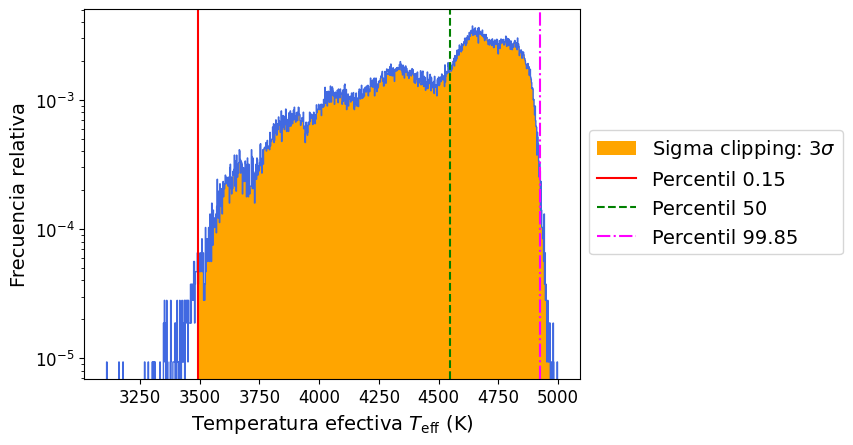

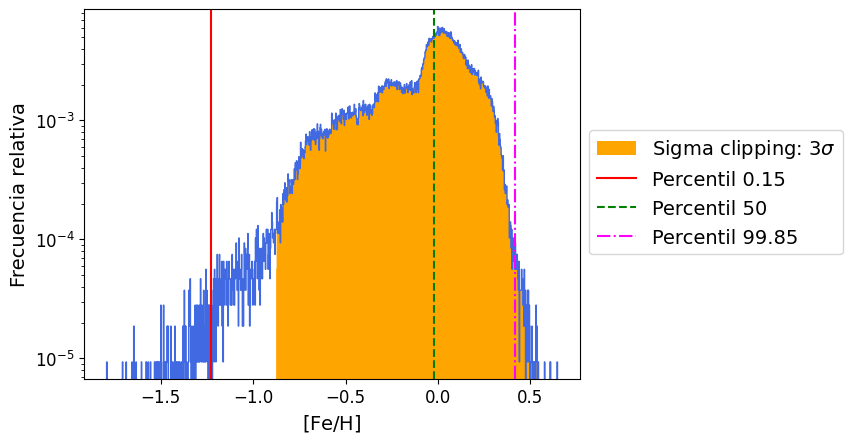

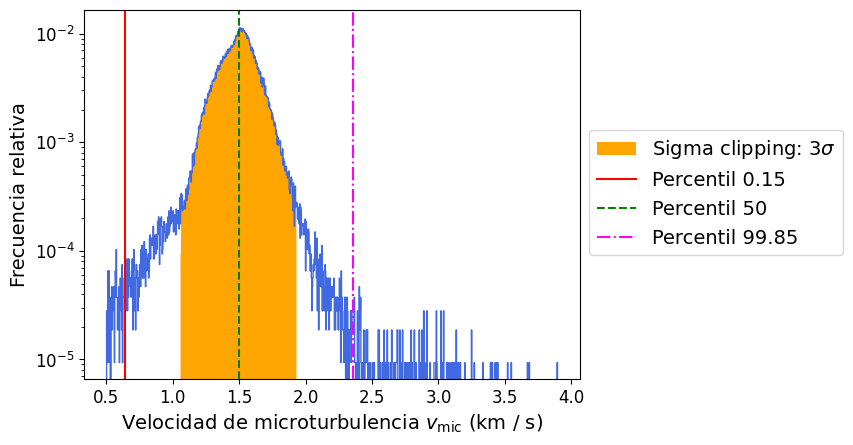

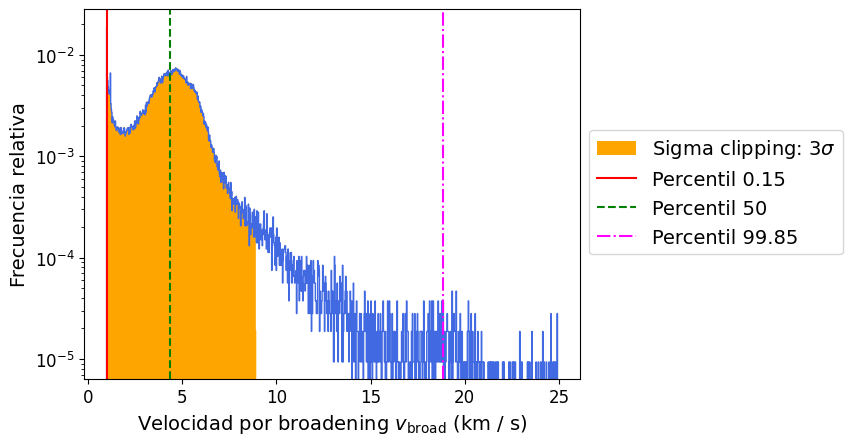

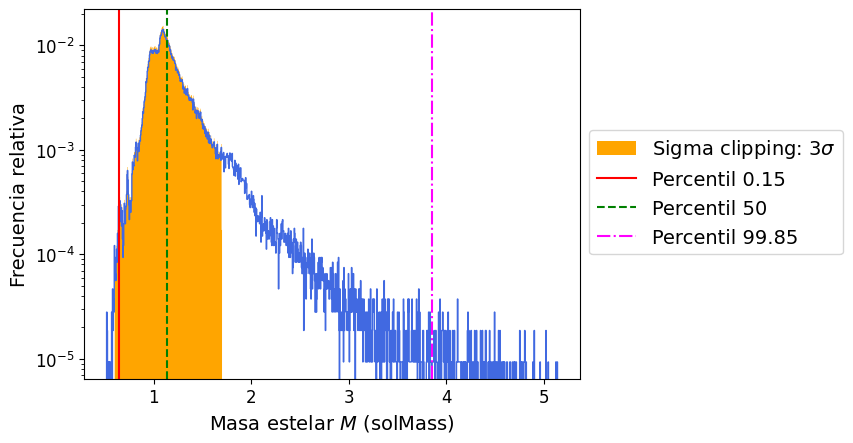

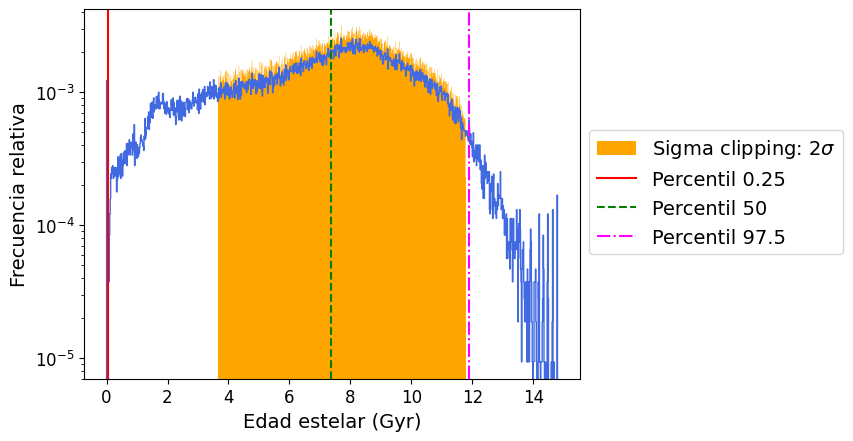

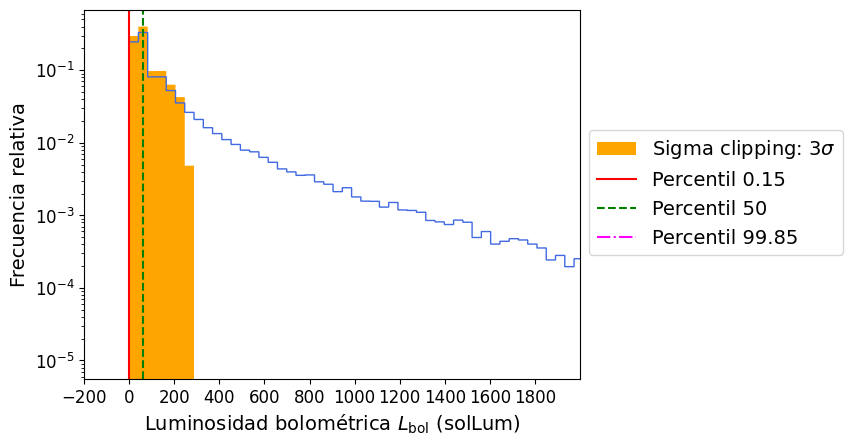

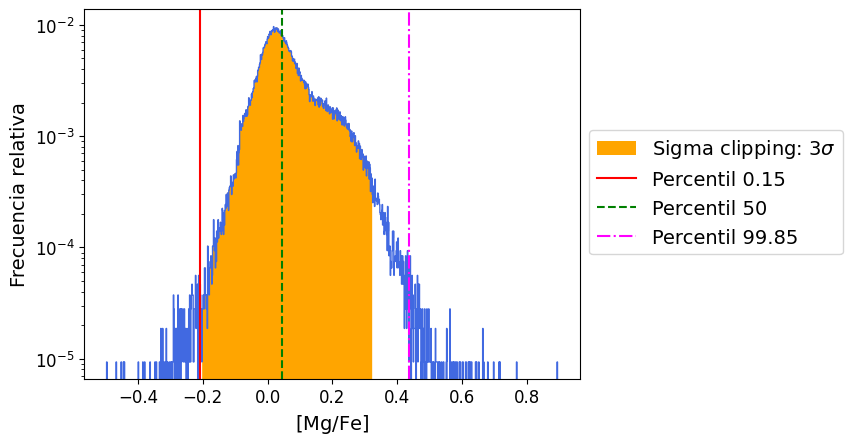

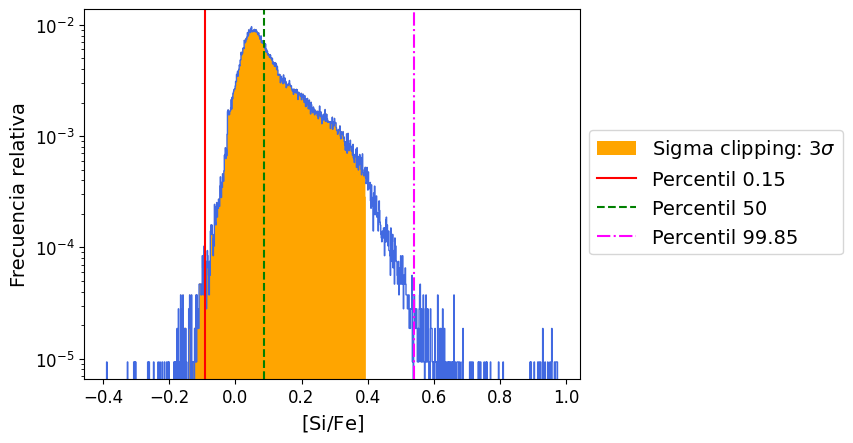

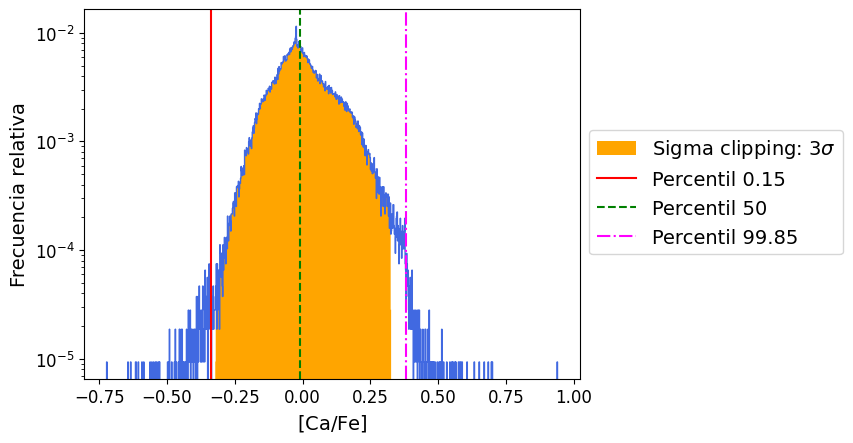

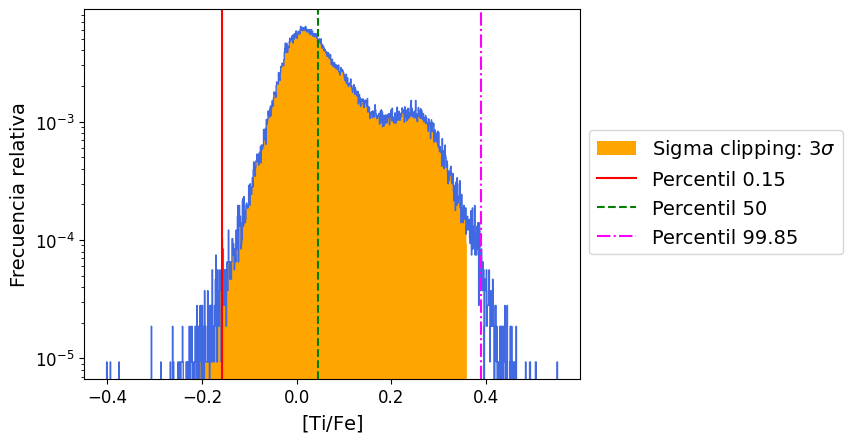

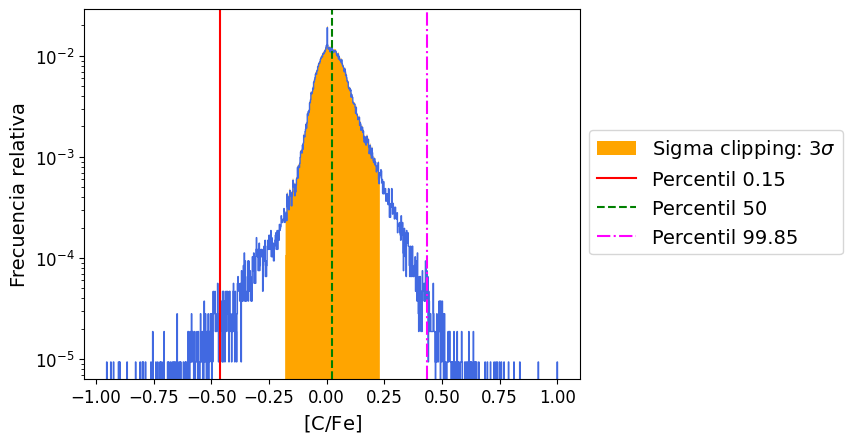

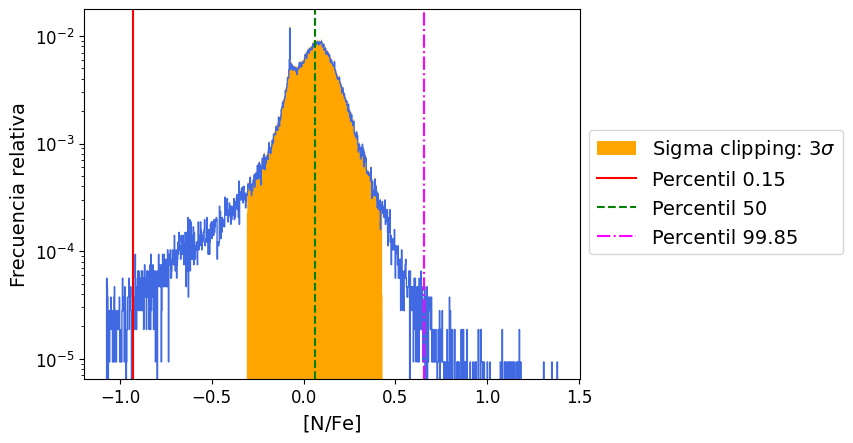

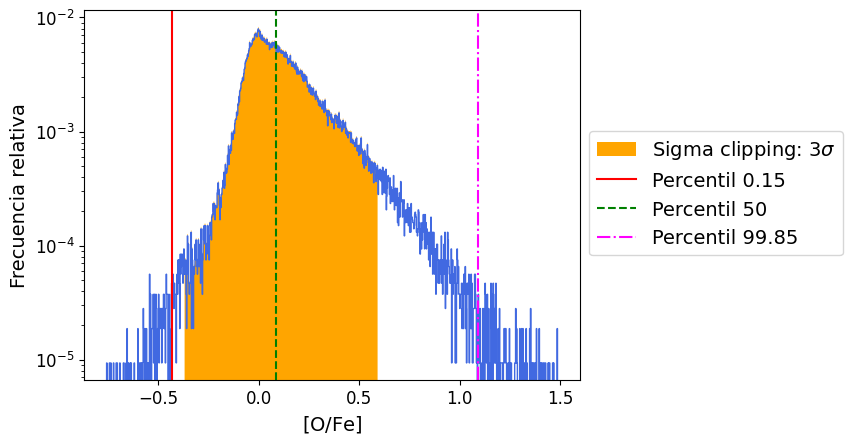

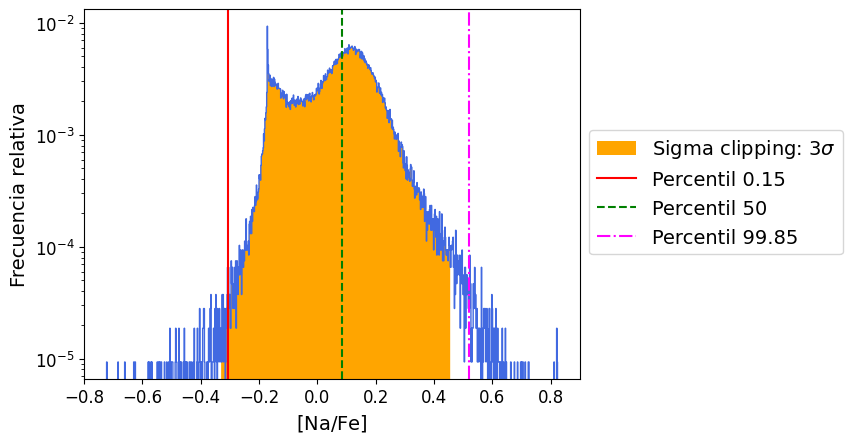

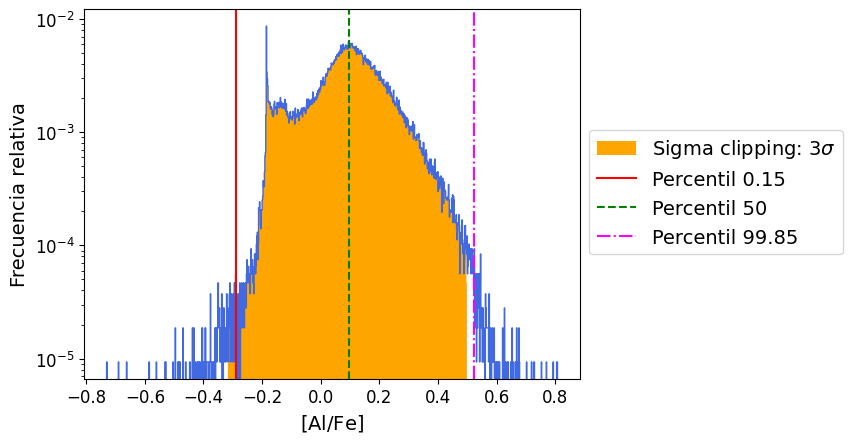

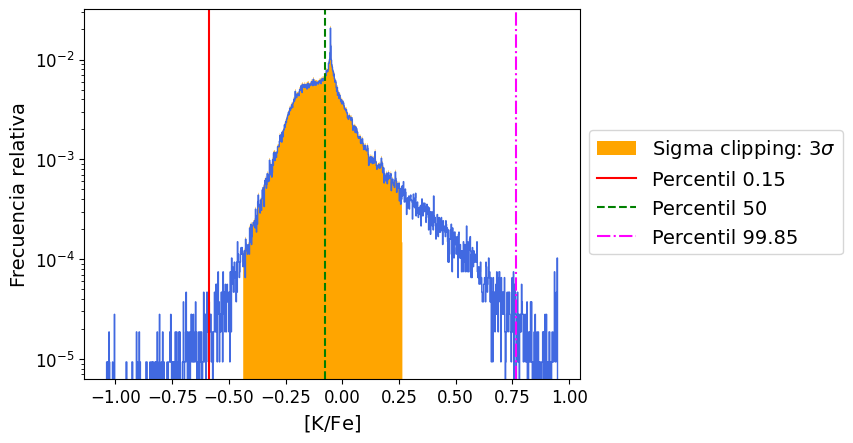

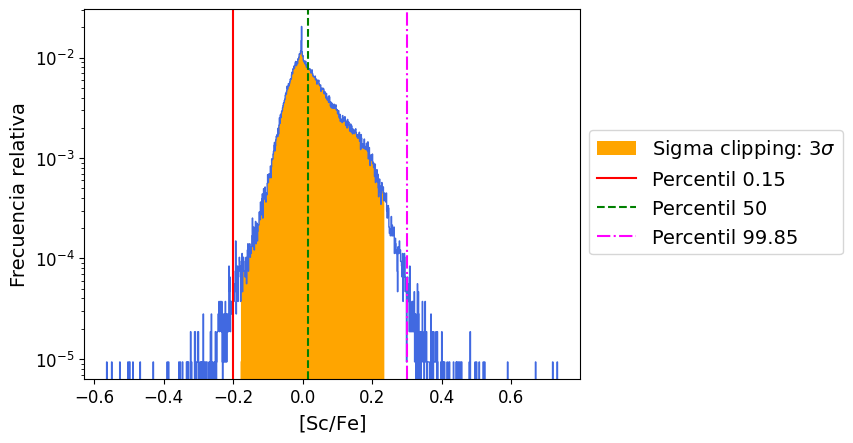

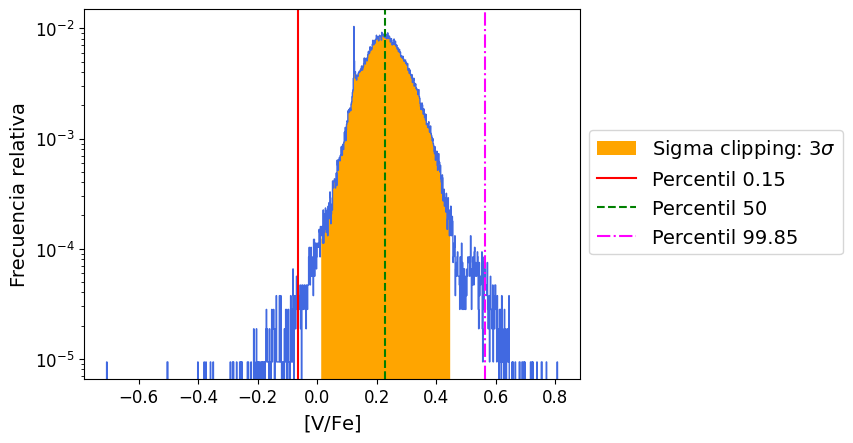

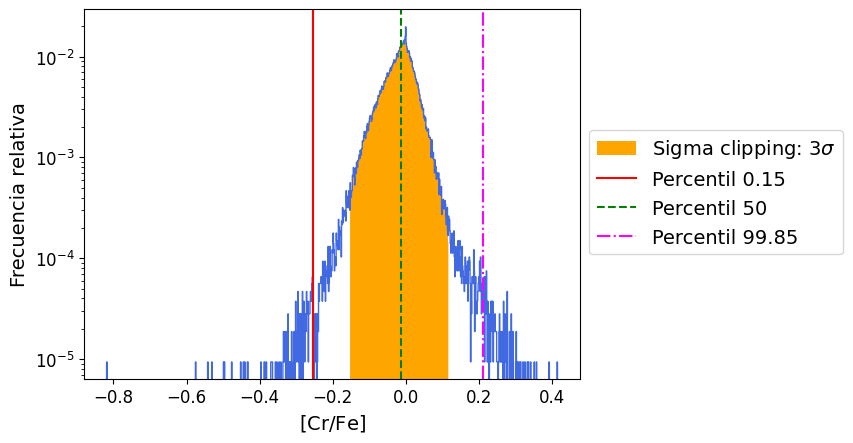

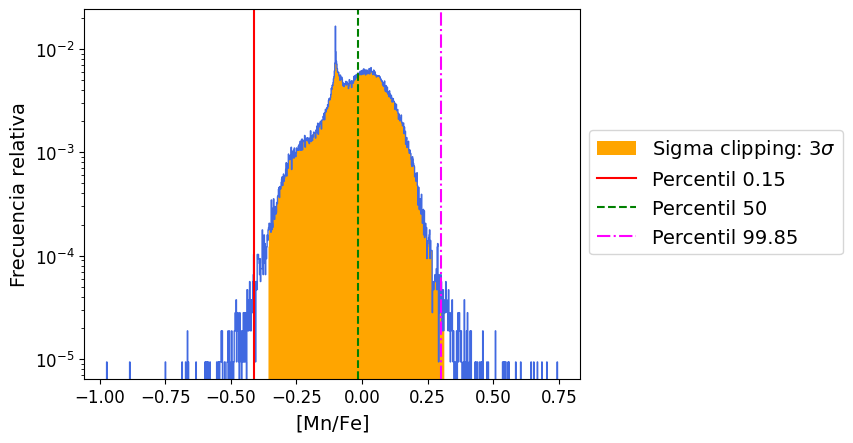

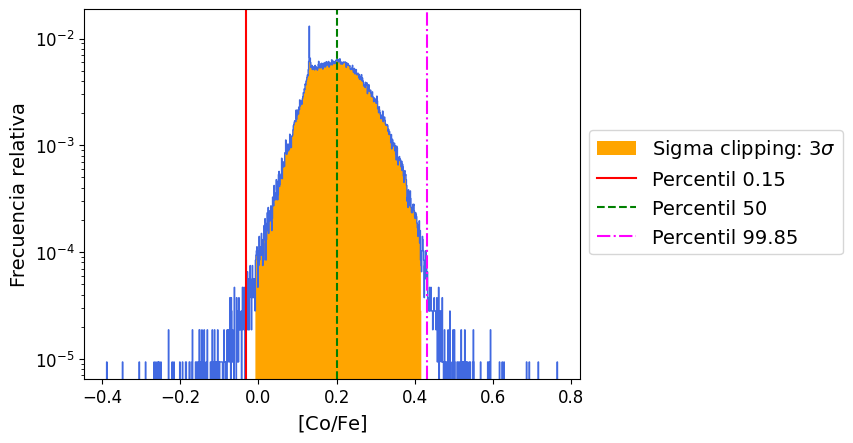

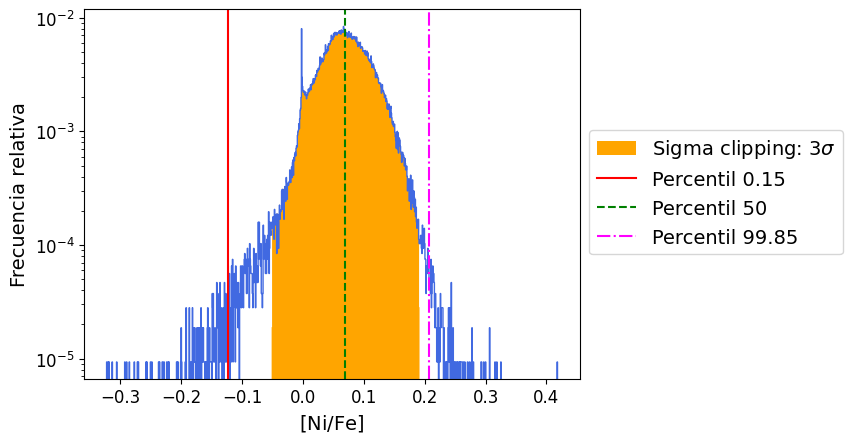

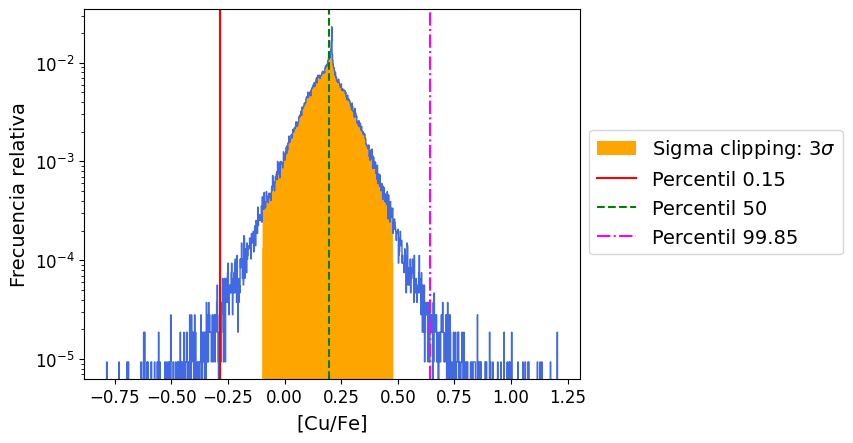

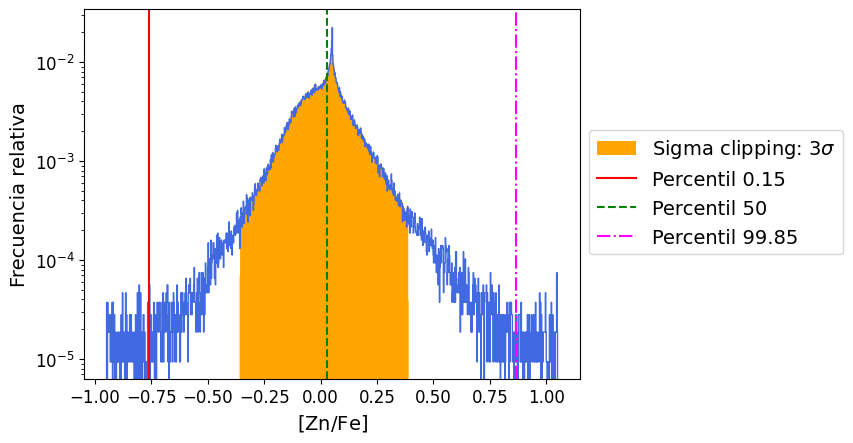

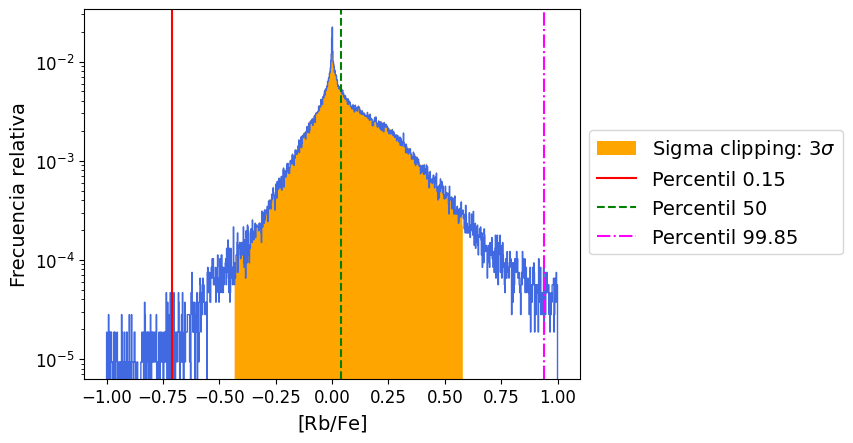

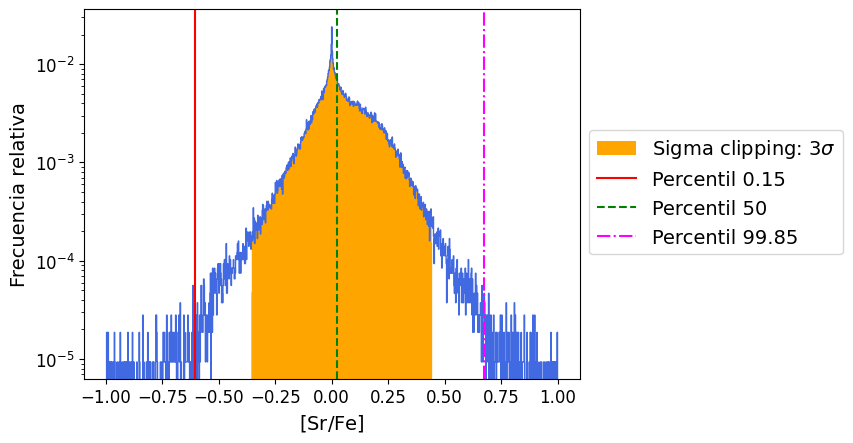

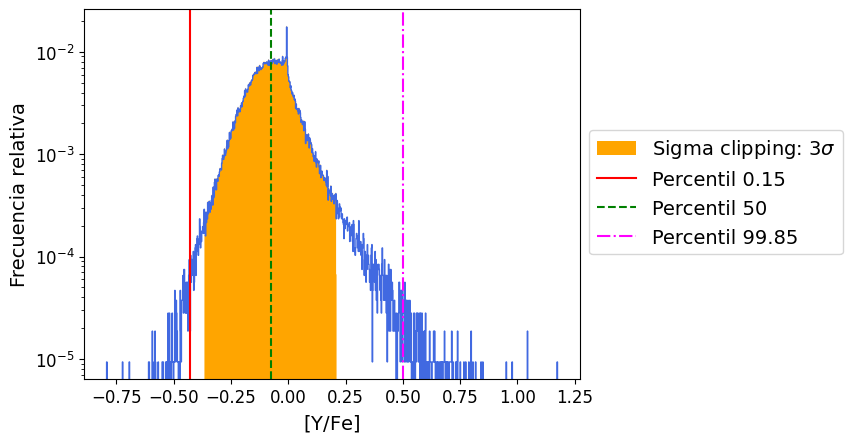

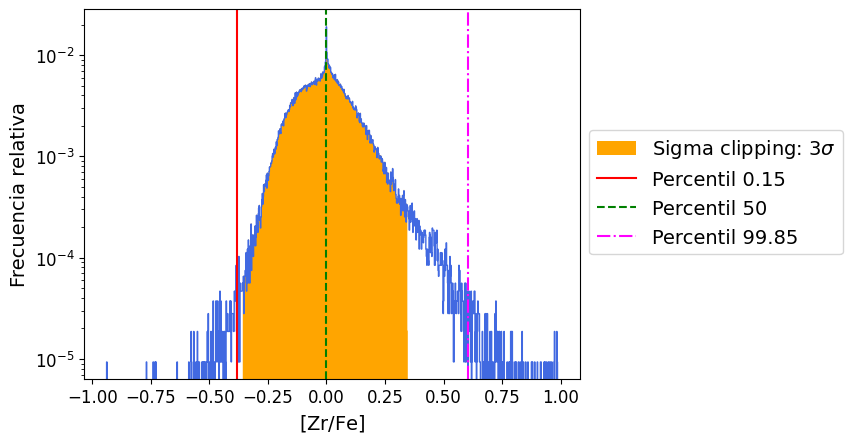

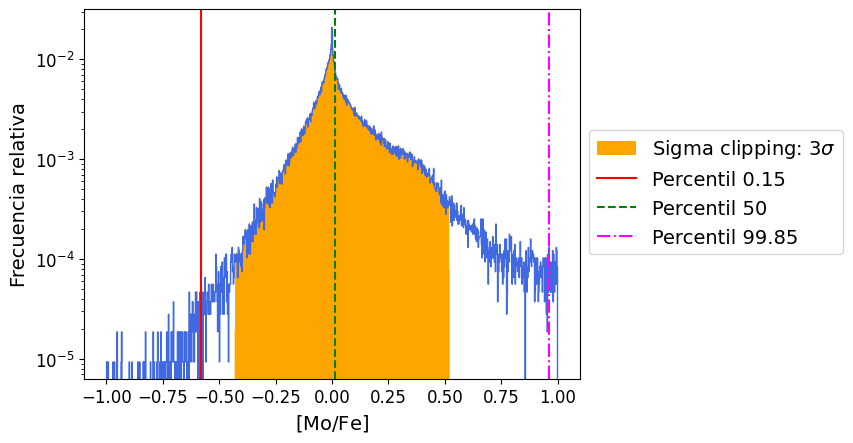

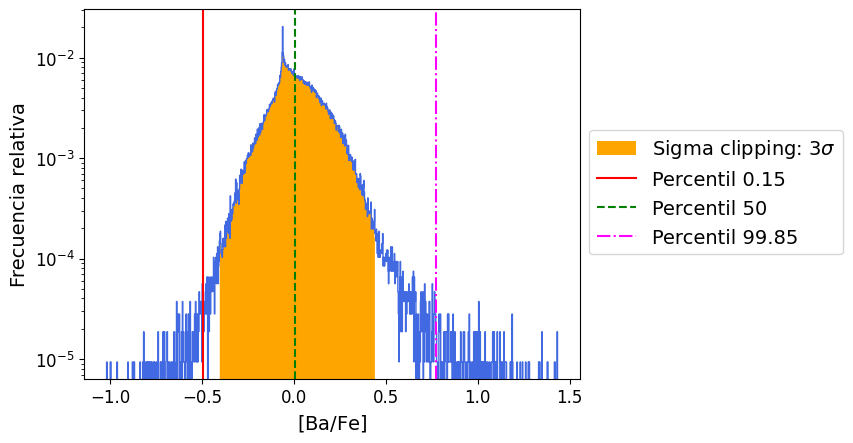

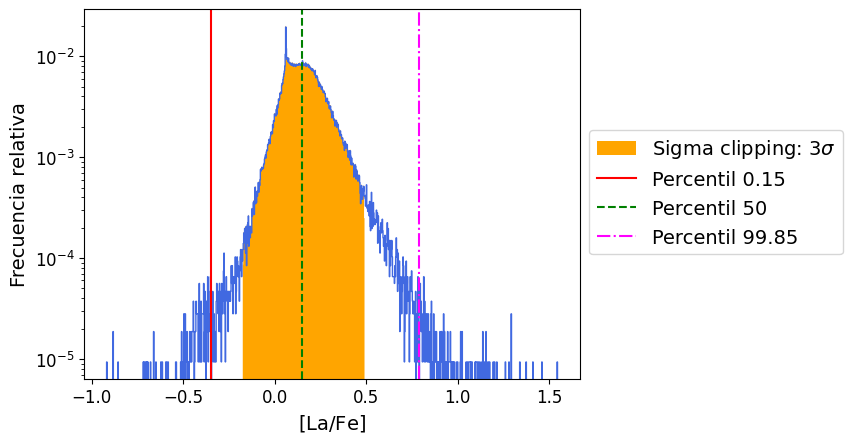

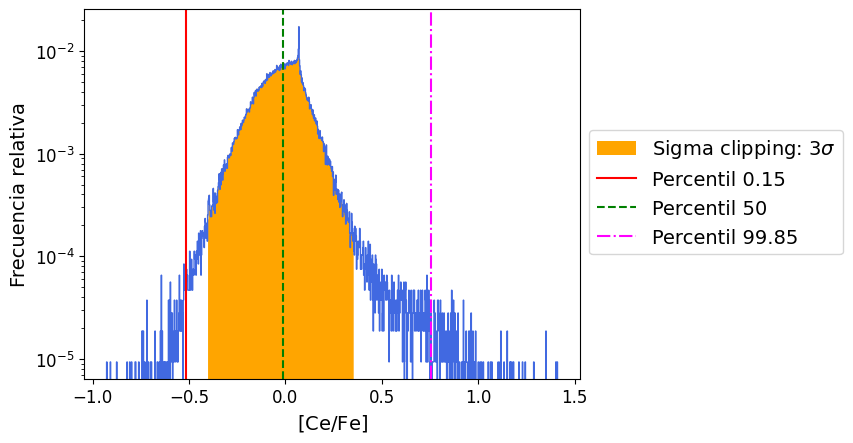

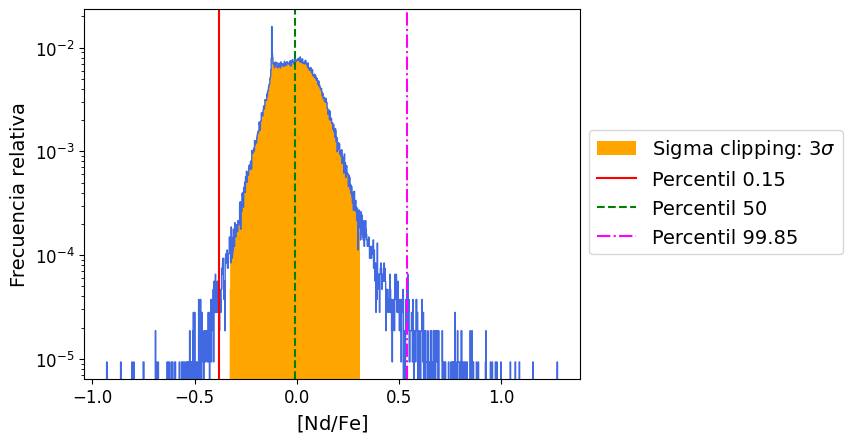

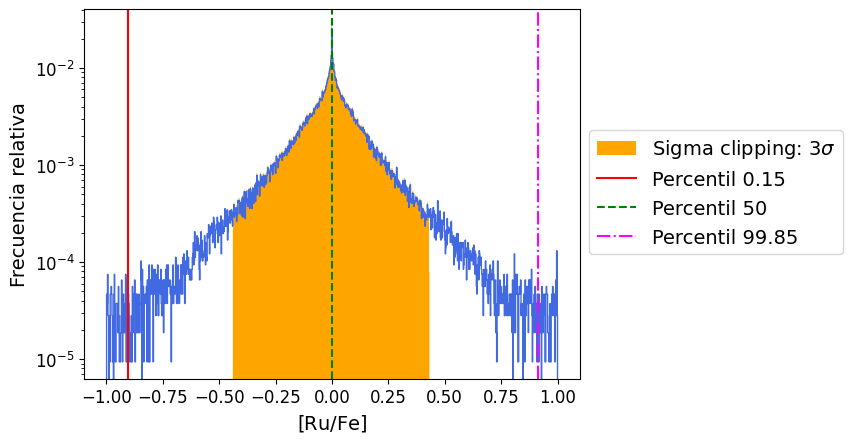

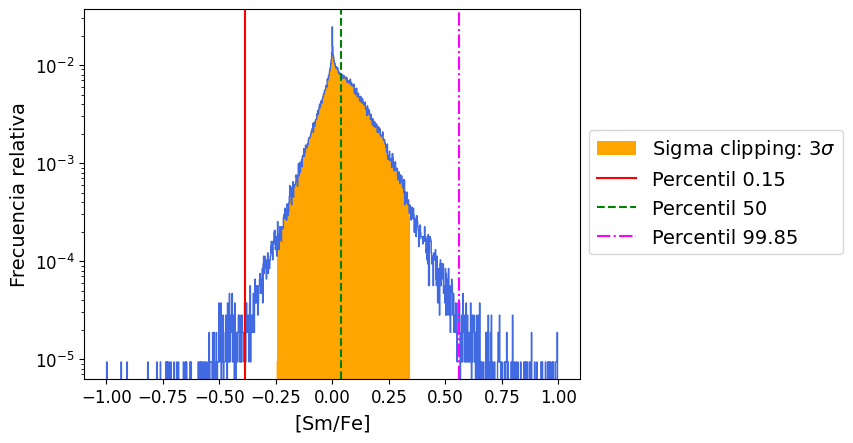

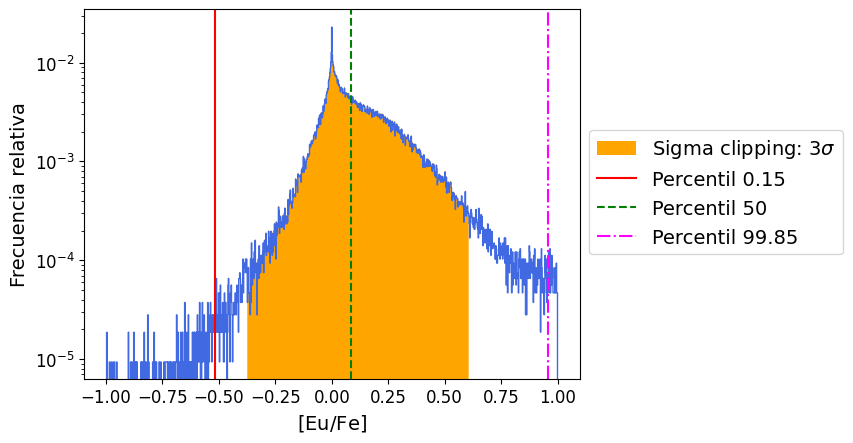

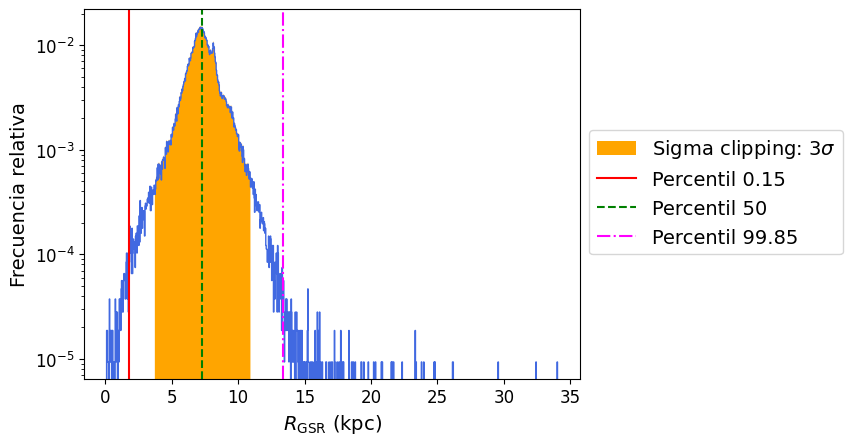

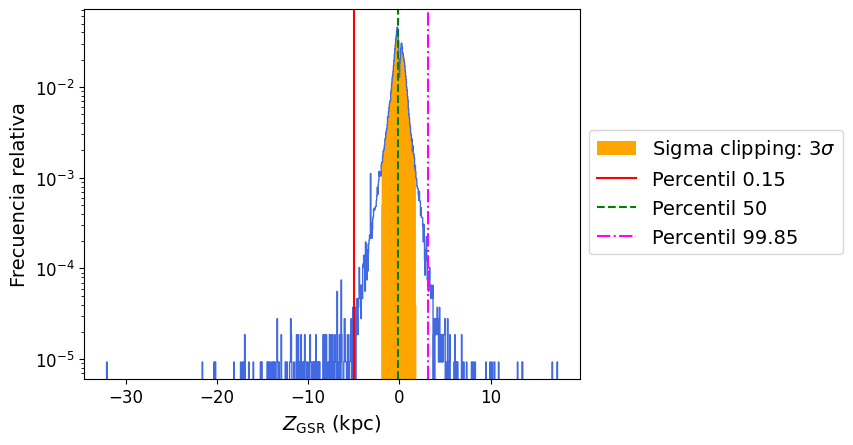

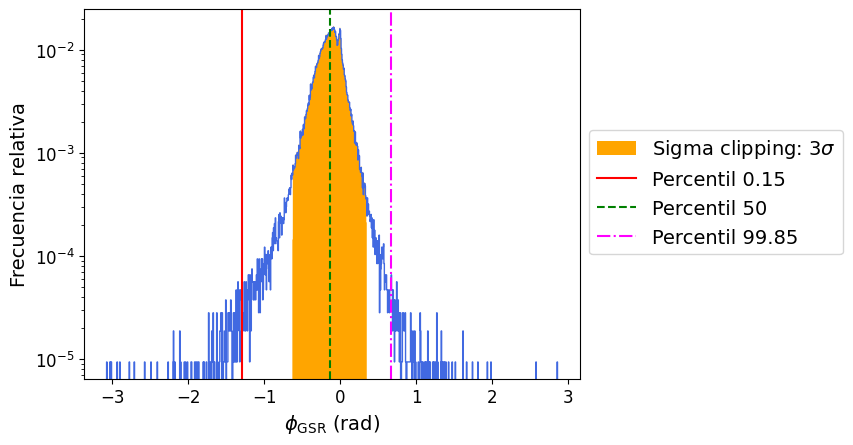

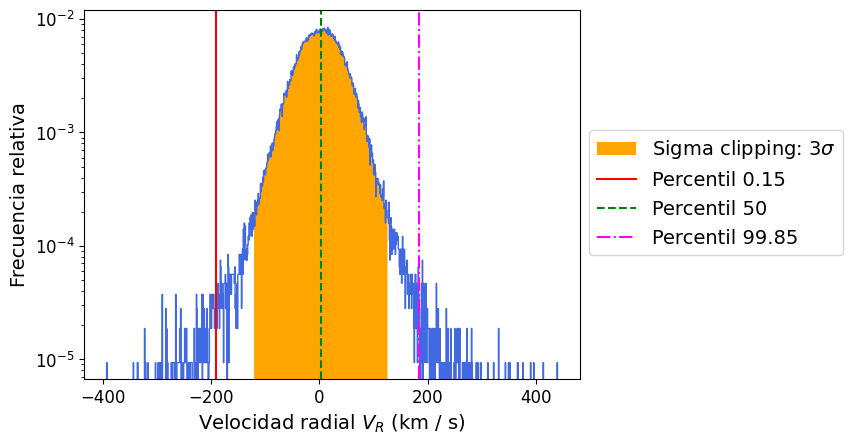

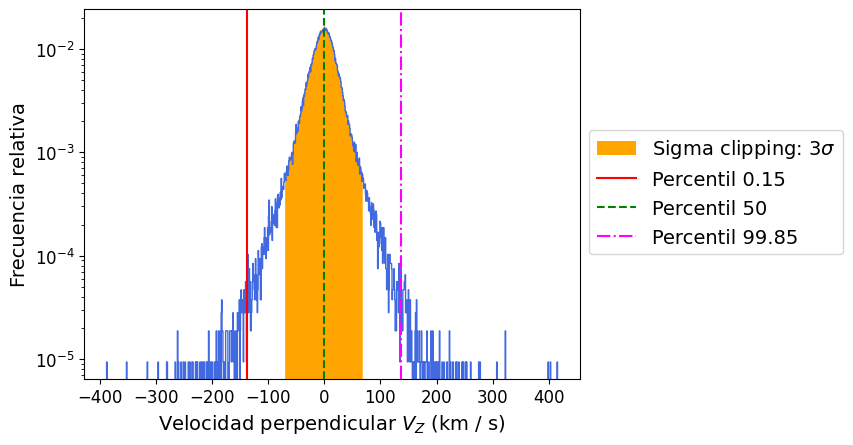

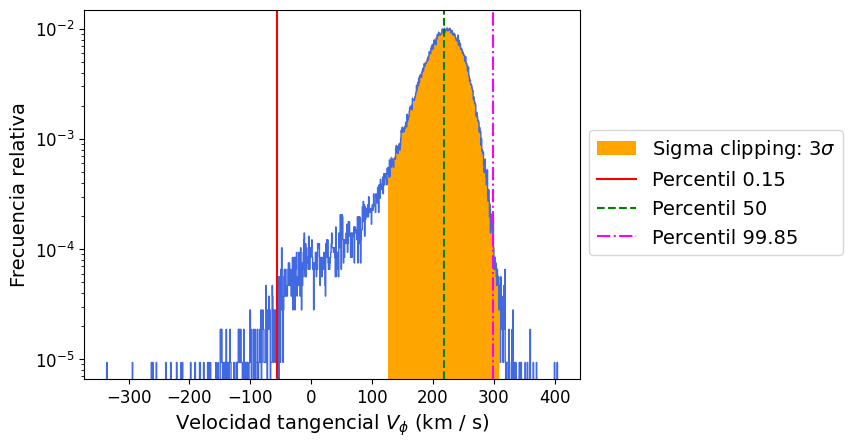

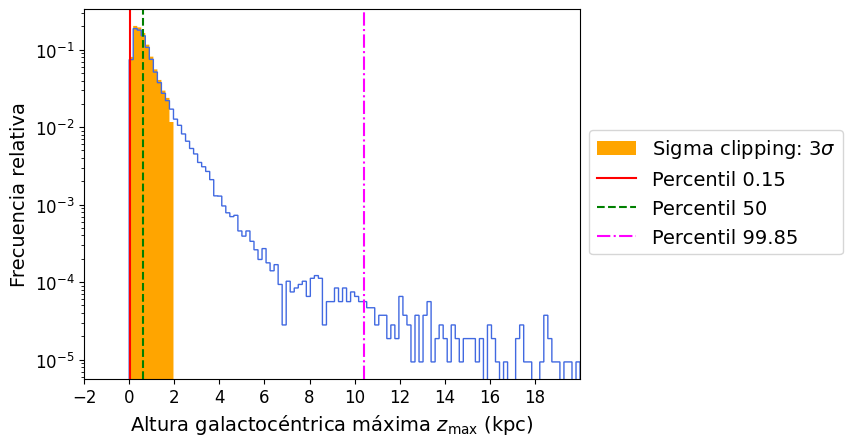

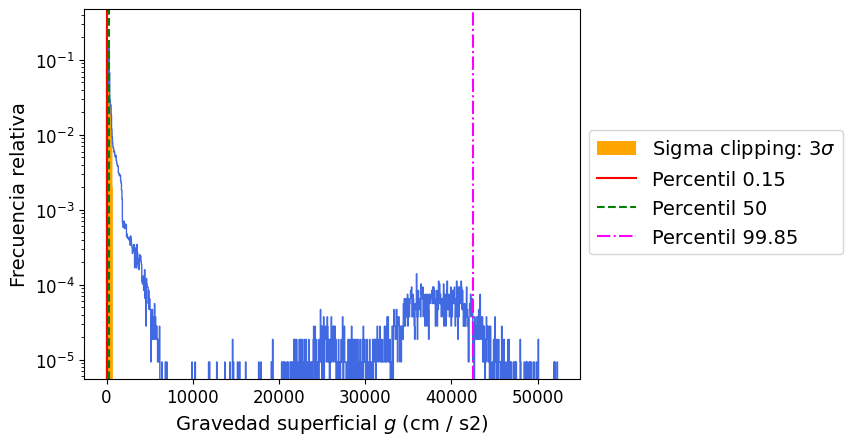

In [72]:
for columna in modelo_1.columnas_finales[1:]:
    if columna in ['age']:
        intervalo_confianza = 95
    else:
        intervalo_confianza = 99.7
    histograma(modelo_1, columna, intervalo_confianza = intervalo_confianza)

## 2.d) Filtrar posibles outliers

Se desprenden dos observaciones de los histogramas:
- El **intervalo de confianza del 99.7%** parece abarcar una porción adecuada de las distribuciones de las estrellas en la mayoría de las propiedades físicas, de manera de **eliminar los outliers**.

- Solo en el caso de la **edad estelar**, convendría usar un **sigma clipping de $2\sigma$** para evitar los sesgos a edades tardías (las edades de estrellas más viejas son más difíciles de estimar) y tempranas.

In [73]:
def filtrar_outliers(modelo: Modelo,
                     intervalo_confianza: float = None ,
                     sigma_clipping: int = None,
                     excepciones: dict[str: float | int] = None) -> pd.DataFrame:
    """
    Filtra el catálogo correspondiente al MODELO, ya sea según un
    INTERVALO_CONFIANZA o SIGMA_CLIPPING (no pueden ser ambos a la vez).
    Se pueden especificar EXCEPCIONES con la forma {COLUMNA: VALOR}, donde
    COLUMNA es el nombre de la columna y VALOR corresponde a un intervalo de
    confianza (float) o sigma clipping (integer).
    Retorna el catálogo filtrado.
    """
    # Solo se puede ingresar un intervalo de confianza o un sigma clipping, no
    # ambos:
    if intervalo_confianza and sigma_clipping:
            texto = 'Elegir intervalo de confianza o sigma clipping, no los dos'
            raise Exception(texto)

    # Columnas del catálogo:
    columnas = modelo.columnas_finales

    # Catálogo que contendrá las estrellas cuyas propiedades físicas cumplan
    # con los filtros establecidos (intervalo de confianza o sigma clipping):
    catalogo_final = modelo.catalogo_sin_nans.copy()

    # Iterar sobre las columnas que se quieren filtrar. La primera es el índice,
    # por lo que no se considera:
    for columna in columnas[1:]:
        # Datos de la columna:
        datos = modelo.catalogo_sin_nans[columna]

        # Si no se especifica una excepción para la COLUMNA, esta se filtra
        # como todas las demás (con un intrevalo de confianza o sigma clipping):
        if not columna in excepciones.keys():
            if intervalo_confianza:
                # Calcular límites mínimo y máximo del intervalo de confianza:
                percentiles, _ = calcular_intervalo_confianza(datos,
                                                        intervalo_confianza)
                minimo, maximo = percentiles

            elif sigma_clipping:
                # Calcular límites mínimo y máximo del sigma clipping:
                sigma = sigma_clipping
                _, minimo, maximo = sigmaclip(datos, low = sigma, high = sigma)

        # Si se especifica una excepción para la columna:
        elif columna in excepciones.keys():
            # Valor del filtro:
            filtro = excepciones[columna]

            # Si el FILTRO es un float, significa que hace referencia a un
            # intervalo de confianza:
            if isinstance(filtro, float):
                # Calcular límites mínimo y máximo del intervalo de confianza:
                percentiles, _ = calcular_intervalo_confianza(datos, filtro)
                minimo, maximo = percentiles

            # Si el FILTRO es un integer, significa que hace referencia a un
            # sigma clipping:
            elif isinstance(filtro, int):
                # Calcular límites mínimo y máximo del sigma clipping:
                _, minimo, maximo = sigmaclip(datos, low = filtro,
                                              high = filtro)
        
        # Filtrar las estrellas de la columna que tengan valores dentro del
        # intervalo definido por ciertos MINIMO y MAXIMO:
        catalogo_final = catalogo_final.loc[
                            (catalogo_final[columna] >= minimo)
                            & (catalogo_final[columna] <= maximo)
                            ]
    
    # Resetear los índices de las estrellas del catálogo:
    catalogo_final.reset_index(drop = True, inplace = True)

    # Imprimir el número de estrellas del catálogo resultante:
    print(f'- {modelo.nombre} - Catálogo sin NaNs y corregido por outliers:',
          f'{len(catalogo_final)} estrellas')
    
    return catalogo_final

In [74]:
modelo_1.catalogo_filtrado = filtrar_outliers(modelo_1, intervalo_confianza = 99.7,
                                            excepciones = {'age': 2})
modelo_1.catalogo_filtrado.head(5)

- Modelo 1 - Catálogo sin NaNs y corregido por outliers: 80797 estrellas


sobject_id         teff      fe_h      vmic     vsini      mass  \
0  140811005001160  4819.867188  0.156381  1.214888  2.498944  1.161967   
1  170910004101289  4366.514160 -0.565017  1.849028  6.531576  1.003146   
2  170828002701216  3893.883789 -0.713241  1.593353  5.745141  0.874649   
3  150828004701010  4670.961426  0.169911  1.352055  1.843184  1.371182   
4  140711003901059  4750.207520  0.209987  1.343378  3.420979  1.216645   

         age        lbol     mg_fe     si_fe  ...     sm_fe     eu_fe  \
0   7.264210    9.799262  0.009314  0.027905  ... -0.065947  0.199954   
1   8.639011  146.775955  0.145063  0.166607  ...  0.230463  0.019208   
2  10.409679  553.885681  0.177635  0.302454  ... -0.036071  0.227240   
3   4.363142   29.451641  0.024736  0.047790  ...  0.065375 -0.001392   
4   6.438471   14.523074 -0.009352 -0.035068  ...  0.082220  0.345465   

    R_Rzphi   z_Rzphi  phi_Rzphi   vR_Rzphi   vz_Rzphi    vT_Rzphi      zmax  \
0  7.774796 -0.679510  -0.075939  16.278175 -14.997689  246.709259  0.828761   
1  9.200190 -4.173048   0.315668  60.378155   6.996849   52.205936  4.735855   
2  7.918680 -1.503439   0.010901  61.444614 -30.529341  206.434921  1.805653   
3  7.538172 -0.957896  -0.137290  33.301712  45.289707  192.420532  1.505263   
4  7.791810 -0.526846  -0.081162  49.891582 -28.233276  200.863678  0.765788   

             g  
0  1580.648804  
1    61.368214  
2     8.966853  
3   547.401001  
4  1053.538696  

[5 rows x 46 columns]

# 3. Coeficientes de correlación no paramétricos <a id="3"></a>

Los **coeficientes de correlación de Pearson (correlación lineal) y Spearman (correlación no necesariamente lineal)** permiten hacerse una idea de los parámetros que debieran estar relacionados. Esto será de utilidad al momento de hacer los árboles de decisión.

In [75]:
def coeficiente_pearson(modelo: Modelo) -> Styler:
    correlaciones_pearson = modelo.catalogo_filtrado.corr(method = 'pearson')
    correlaciones_pearson = correlaciones_pearson.style.background_gradient(cmap = 'coolwarm')
    correlaciones_pearson.set_caption("Coeficiente de correlación de Pearson")
    return correlaciones_pearson

def coeficiente_spearman(modelo: Modelo) -> Styler:
    correlaciones_pearson = modelo.catalogo_filtrado.corr(method = 'spearman')
    correlaciones_pearson = correlaciones_pearson.style.background_gradient(cmap = 'coolwarm')
    correlaciones_pearson.set_caption("Coeficiente de correlación de Spearman")
    return correlaciones_pearson

In [76]:
modelo_1.correlaciones_pearson = coeficiente_pearson(modelo_1)
modelo_1.correlaciones_pearson

In [77]:
modelo_1.correlaciones_spearman = coeficiente_spearman(modelo_1)
modelo_1.correlaciones_spearman

# 4. Categorización de estrellas de diferentes componentes galácticas: disco delgado, grueso y halo <a id="4"></a>

## 4.a) Diagrama de Toomre

En un **diagrama de Toomre**, se grafica $v$ vs. $\sqrt{u^2 + w^2}$, donde:
- $u$: componente **radial** de la **velocidad peculiar** de la estrella
- $v$: componente **tangencial** de la **velocidad peculiar** de la estrella
- $w$: componente **perpendicular al plano galáctico** de la **velocidad peculiar** de la estrella

La **velocidad peculiar** $\vec{V}=(u,v,w)$ de una estrella es su velocidad respecto al **Local Standard of Rest (LSR)** como:
\begin{align*}
\vec{V} = (u,v,w) \equiv (V_R, V_{\phi}, V_Z) - (V_R, V_\phi, V_Z)_{\mathrm{LSR}}
\end{align*}
- $V_R$: **velocidad radial** (galactocéntrica) de la estrella
- $V_{\phi}$: **velocidad tangencial** (galactocéntrica) de la estrella
- $V_Z$: **velocidad de la estrella perpendicular al plano galáctico**
- $(V_R, V_\phi, V_Z)_{\mathrm{LSR}} = (0, 240, 0)\,km/s$: velocidad del LSR (Gaia Collaboration et al. 2018)

In [78]:
# Crear colormap:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
            (0, '#ffffff'),
            (1e-20, '#440053'),
            (0.2, '#404388'),
            (0.4, '#2a788e'),
            (0.6, '#21a784'),
            (0.8, '#78d151'),
            (1, '#fde624'),
        ], N = 256)

In [79]:
def diagrama_de_toomre(modelo: Modelo,
                       xlims: tuple[float, float, float] = None,
                       ylims: tuple[float, float, float] = None) -> None:
    # Velocidades:
    velocidad_radial = modelo.catalogo_filtrado['vR_Rzphi']
    velocidad_perpendicular = modelo.catalogo_filtrado['vz_Rzphi']
    velocidad_tangencial = modelo.catalogo_filtrado['vT_Rzphi'] - 240

    # Crear subplot:
    # fig = plt.figure(dpi = 144)
    # ax = fig.add_subplot(1, 1, 1, projection = 'scatter_density')
    fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 144)

    # Hacer gráfico de densidad:
    x = velocidad_tangencial
    y = np.sqrt(velocidad_radial ** 2 + velocidad_perpendicular ** 2)

    histograma = plt.hist2d(x, y, bins = 200, cmap = white_viridis)
    colorbar = fig.colorbar(histograma[3])
    colorbar.set_label(label = 'Número de estrellas por pixel', fontsize = 14)

    # Graficar círculos:
    posicion_central = (0, 0)
    circulo_1 = plt.Circle(posicion_central, radius = 50, color = 'red',
                           fill = False, linestyle = ':', linewidth = 2.,
                           label = r'$\vert\vec{V}\vert = 50\,km/s$')
    circulo_2 = plt.Circle(posicion_central, radius = 70, color = 'turquoise',
                           fill = False, linestyle = '-.', linewidth = 2.,
                           label = r'$\vert\vec{V}\vert = 70\,km/s$')
    circulo_3 = plt.Circle(posicion_central, radius = 180, color = 'fuchsia',
                           fill = False, linestyle = '--', linewidth = 2.,
                           label = r'$\vert\vec{V}\vert = 180\,km/s$')
    
    ax.add_patch(circulo_1)
    ax.add_patch(circulo_2)
    ax.add_patch(circulo_3)
    
    # Límites del gráfico:
    if xlims:
        ax.set_xticks(np.arange(xlims[0], xlims[1], xlims[2]))
        plt.xlim([xlims[0], xlims[1]])
    
    if ylims:
        ax.set_yticks(np.arange(ylims[0], ylims[1], ylims[2]))
        plt.ylim([ylims[0], ylims[1]])
    
    # Parámetros del gráfico:
    plt.xticks(size = 12)
    plt.yticks(size = 12)

    plt.xlabel(r'$v$ ($km/s$)', fontsize = 14)
    plt.ylabel(r'$\sqrt{u^2 + w^2}$ ($km/s$)', fontsize = 14)

    plt.title('Diagrama de Toomre', fontsize = 18)

    plt.legend(loc = 'upper left', fontsize = 12)

    # Corregir relación de aspecto del gráfico:
    plt.gca().set_aspect('equal', adjustable = 'box')

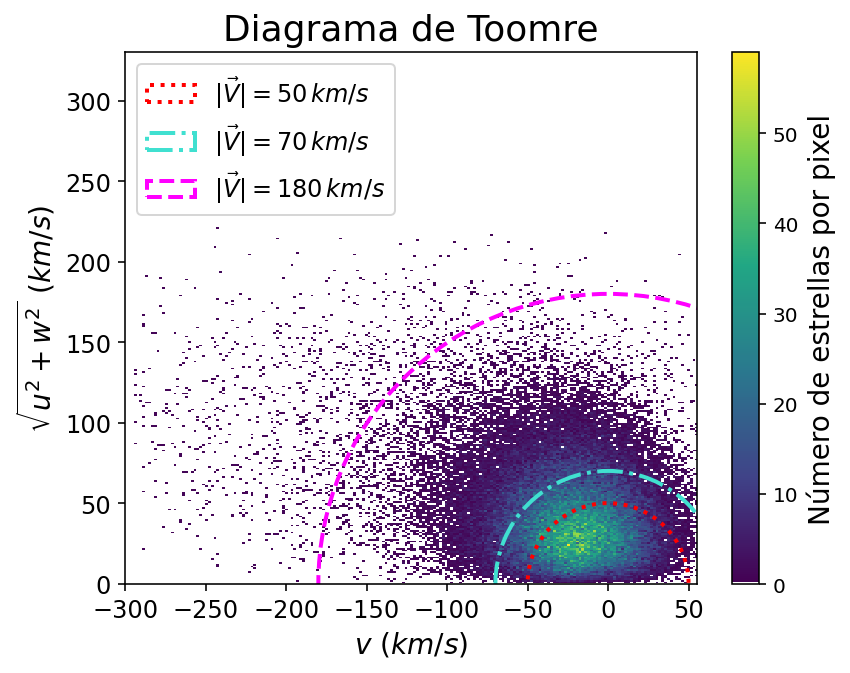

In [80]:
diagrama_de_toomre(modelo_1,
                   xlims = (-300, 55, 50),
                   ylims = (0, 330, 50))

Según da Silva et al. (2023), se puede categorizar la componente galáctica a la que pertenece cada estrella, por medio del **cuadrado del módulo de su velocidad peculiar** $\vert\vec{V}\vert = \sqrt{u^2 + v^2 + w^2}$:
- **Disco delgado:** $\vert\vec{V}\vert < 50\,km/s$
- **Disco grueso:** $\vert\vec{V}\vert \in (70, 180)\,km/s$
- **Halo:** $\vert\vec{V}\vert > 180\,km/s$

En la región $\vert\vec{V}\vert \in (50,70)\,km/s$, **puede haber tanto estrellas del disco delgado como del disco grueso**.

## 4.b) Agregar columna $\vert\vec{V}\vert$ y usarla para clasificar las estrellas según su región galáctica

Primero, se calcula $\vert\vec{V}\vert$ para cada estrella, y luego se clasifica la **región galáctica a la que pertenece** según el valor de $\vert\vec{V}\vert$ (da Silva et al. 2023).

In [81]:
# Lista que contendrá el módulo de la velocidad peculiar de cada estrella:
lista_mod_V= []

# Lista que contendrá la región galáctica a la que pertenecería cada estrella:
lista_reg_gal = []

# Listas que contendrá un booleano (0 o 1) para cada estrella, con tal de
# indicar si pertenece a la región galáctica correspondiente:
lista_disco_delgado = [] # Disco delgado
lista_disco_grueso = [] # Disco grueso
lista_halo = [] # Halo

for _, tupla in modelo_1.catalogo_filtrado.iterrows():
    # Componentes de la velocidad peculiar:
    velocidad_radial = tupla['vR_Rzphi']
    velocidad_tangencial = tupla['vT_Rzphi'] - 240
    velocidad_perpendicular = tupla['vz_Rzphi']

    # Módulo de la velocidad peculiar:
    mod_V = np.sqrt(velocidad_radial ** 2 + velocidad_tangencial ** 2
             + velocidad_perpendicular ** 2)
    lista_mod_V.append(mod_V) # Agregar a la lista
    
    # Clasificar la región galáctica a la que pertenece cada estrella según el
    # valor del módulo de su velocidad peculiar:
    disco_delgado, disco_grueso, halo = 0, 0, 0
    if mod_V < 50.:
        disco_delgado = 1
        reg_gal = 'Disco delgado'
    elif 70. < mod_V < 180.:
        disco_grueso = 1
        reg_gal = 'Disco grueso'
    elif mod_V > 180.:
        halo = 1
        reg_gal = 'Halo'
    else:
        reg_gal = 'Inconcluso'

    # Agregar a las listas correspondientes:
    lista_disco_delgado.append(disco_delgado)
    lista_disco_grueso.append(disco_grueso)
    lista_halo.append(halo)
    lista_reg_gal.append(reg_gal)

# Crear nuevo catálogo:
modelo_1.catalogo_final = modelo_1.catalogo_filtrado.copy()

# Agregar al catálogo:
modelo_1.catalogo_final['mod_V'] = lista_mod_V
modelo_1.catalogo_final['disco_delgado'] = lista_disco_delgado
modelo_1.catalogo_final['disco_grueso'] = lista_disco_grueso
modelo_1.catalogo_final['halo'] = lista_halo
modelo_1.catalogo_final['reg_gal'] = lista_reg_gal

Ahora, **solo sirven las estrellas cuya región galáctica pueda ser determinada**. Por ende, **se descartan todas las estrellas para la cuales no se pueda determinar su región galáctica**:

In [82]:
modelo_1.catalogo_clasificado = modelo_1.catalogo_final.copy()

modelo_1.catalogo_clasificado = modelo_1.catalogo_clasificado[
    modelo_1.catalogo_clasificado['reg_gal'] != 'Inconcluso']

modelo_1.catalogo_clasificado.reset_index(drop = True, inplace = True)
modelo_1.catalogo_clasificado.head(5)

sobject_id         teff      fe_h      vmic     vsini      mass  \
0  140811005001160  4819.867188  0.156381  1.214888  2.498944  1.161967   
1  170910004101289  4366.514160 -0.565017  1.849028  6.531576  1.003146   
2  170828002701216  3893.883789 -0.713241  1.593353  5.745141  0.874649   
3  150828004701010  4670.961426  0.169911  1.352055  1.843184  1.371182   
4  170711005801306  4037.070068 -0.562671  1.592211  3.740058  0.943281   

         age        lbol     mg_fe     si_fe  ...    vR_Rzphi   vz_Rzphi  \
0   7.264210    9.799262  0.009314  0.027905  ...   16.278175 -14.997689   
1   8.639011  146.775955  0.145063  0.166607  ...   60.378155   6.996849   
2  10.409679  553.885681  0.177635  0.302454  ...   61.444614 -30.529341   
3   4.363142   29.451641  0.024736  0.047790  ...   33.301712  45.289707   
4  10.207219  321.647125  0.191233  0.318600  ... -107.884804  20.743784   

     vT_Rzphi      zmax            g       mod_V  disco_delgado  disco_grueso  \
0  246.709259  0.828761  1580.648804   23.128420              1             0   
1   52.205936  4.735855    61.368214  197.385632              0             0   
2  206.434921  1.805653     8.966853   76.381253              0             1   
3  192.420532  1.505263   547.401001   73.647589              0             1   
4  245.909363  3.313861    19.240713  110.019798              0             1   

   halo        reg_gal  
0     0  Disco delgado  
1     1           Halo  
2     0   Disco grueso  
3     0   Disco grueso  
4     0   Disco grueso  

[5 rows x 51 columns]

In [83]:
def histograma_region_galactica(dataframe: pd.DataFrame,
                                color: str,
                                label: str) -> None:
    # Catálogo de estrellas:
    catalogo = dataframe

    # Región galáctica de las estrellas:
    region_galactica = catalogo['reg_gal']
        
    # Normalización de la muestra de datos:
    normalizacion = np.ones_like(region_galactica) / len(region_galactica)

    # Histograma:
    plt.hist(region_galactica, log = True, color = color,
                align = 'mid', weights = normalizacion, alpha = 0.5,
                label = label)

In [84]:
def histogramas_region_galactica(modelo: Modelo,
                                  xlims: tuple[float, float, float] = None,
                                  ylims: tuple[float, float, float] = None,
                                  equilibrado = False) -> None:
    # Crear figura:
    fig_1, ax_1 = plt.subplots(nrows = 1, ncols = 1, dpi = 144)

    # Muestra equilibrada (proporción de estrellas en el halo, disco delgado y
    # grueso igualada):
    if equilibrado:
        label_equilibrado = ('Muestra equilibrada:',
                             f'{len(modelo.catalogo_equilibrado)} estrellas')
        histograma_region_galactica(modelo.catalogo_equilibrado,
                                    color = 'red',
                                    label = ' '.join(label_equilibrado))
        
        # Mostrar línea horizontal en el límite de los bins:
        plt.axhline(y = 0.33333, xmin = 0., xmax = 2., color = 'red',
                    linestyle = '--', alpha = 0.5)

    # Muestra sin equilibrar (proporción de estrellas en el halo, disco delgado
    # y grueso sin alterar):
    label_sin_equilibrar = ('Muestra sin equilibrar:',
                            f'{len(modelo.catalogo_clasificado)} estrellas')
    histograma_region_galactica(modelo.catalogo_clasificado,
                                color = 'royalblue',
                                label = ' '.join(label_sin_equilibrar))

    # Parámetros del gráfico:
    ## Títulos de los ejes:
    plt.ylabel('Frecuencia relativa', fontsize = 14)

    ## Límites de los ejes:
    plt.ylim([0., 10.])

    ## Cambiar posición de cada etiqueta en el eje horizontal:
    x = np.array([0.05, 1.05, 1.85])
    ax_1.set_xticks(x + 0.1 / 2)

    ## Otros:
    plt.xticks(size = 12)
    plt.yticks(size = 12)

    plt.title('No. de estrellas por región galáctica', fontsize = 18)
    plt.legend(loc = 'upper right', fontsize = 14)#, bbox_to_anchor = (1.55, 0.7))
    plt.grid(axis = 'y')

/var/folders/hy/sg3cpy4j0yq2njjnh02z2ql40000gn/T/ipykernel_1124/4274663007.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0., 10.])


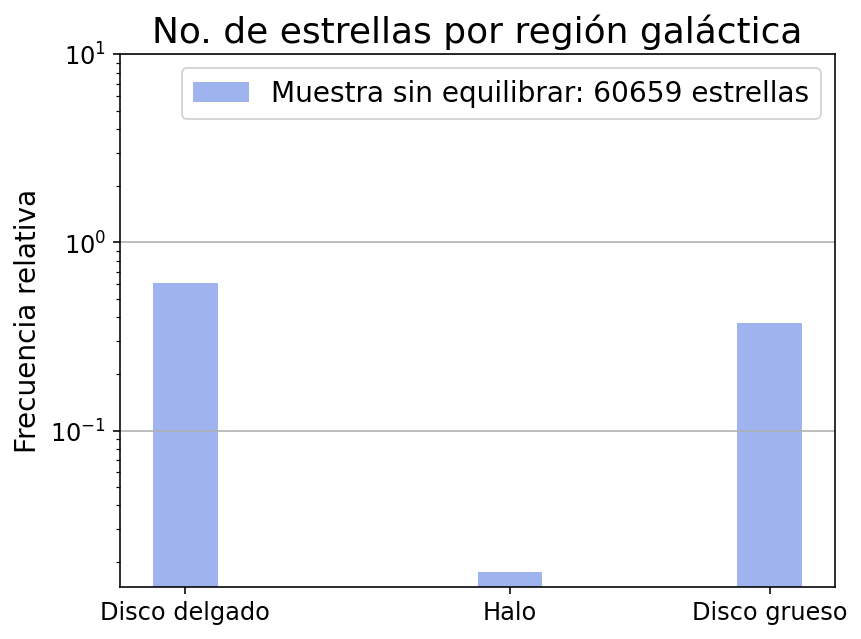

In [85]:
histogramas_region_galactica(modelo_1, equilibrado = False)

## 4.c) Corregir distribución en las diferentes regiones galácticas

Se aprecia que **el número de estrellas observadas en el halo es mucho mayor que en el disco grueso, y muchísimo mayor que en el disco delgado**.

Una forma de contrarrestar esto puede ser **copiar las estrellas de los discos grueso y delgado hasta que la muestra contenga la misma cantidad de estrellas del halo, disco grueso y disco delgado**.

In [86]:
def rellenar_dataframe(dataframe: pd.DataFrame,
                       columna: str,
                       valor: str,
                    largo_objetivo: int) -> None:
    """
    Rellenar el DATAFRAME con elementos que tengan un cierto VALOR en
    determinada COLUMNA, hasta alcanzar un LARGO_OBJETIVO.
    """
    # DataFrame de elementos que tienen el VALOR en la COLUMNA:
    dataframe_elementos = dataframe[dataframe[columna] == valor]

    # Número de elementos con el VALOR:
    no_elementos_existentes = len(dataframe_elementos)
    
    # Número de elementos que faltan por rellenar:
    no_elementos_faltantes = largo_objetivo - no_elementos_existentes

    # Si ya tiene la cantidad de elementos indicada (o más), imprimir esto:
    if no_elementos_faltantes <= 0:
        print(f'{columna}: la lista ya tiene la cantidad de elementos deseada')
        return dataframe

    # Número de iteraciones en que se puede copiar el DataFrame completo sin
    # pasarse del LARGO_OBJETIVO:
    no_iteraciones = int(no_elementos_faltantes / no_elementos_existentes)

    # Nuevo DataFrame que contendrá el LARGO_OBJETIVO de tuplas con VALOR en COLUMNA:
    nuevo_dataframe = dataframe.copy()
    
    # Copiar el DataFrame original NO_ITERACIONES veces, para tuplas que tengan el
    # VALOR en la COLUMNA:
    condicion = nuevo_dataframe[columna] == valor # Condición: tuplas con VALOR en COLUMNA
    if no_iteraciones > 0:
        #for indice in range(no_iteraciones):
        tuplas = nuevo_dataframe[condicion]
        tuplas = tuplas.loc[tuplas.index.repeat(no_iteraciones)]
        nuevo_dataframe = pd.concat([nuevo_dataframe, tuplas], axis = 0)

    # Si aún faltan elementos para llegar al LARGO_OBJETIVO:
    resto = no_elementos_faltantes % no_elementos_existentes
    if resto > 0:
        # Seleccionar las primeras RESTO tuplas con VALOR en COLUMNA:
        tuplas = nuevo_dataframe[condicion].head(resto)
        nuevo_dataframe = pd.concat([nuevo_dataframe, tuplas], axis = 0)
    
    return nuevo_dataframe.reset_index(drop = True)
    

In [87]:
def equilibrar_regiones(modelo: Modelo) -> None:
    """
    Copiar estrellas de los discos delgado y grueso hasta que haya
    la misma cantidad en cada región: halo, disco delgado y disco grueso.
    """
    # Catálogo de estrellas:
    catalogo = modelo.catalogo_clasificado

    # Región galáctica de las estrellas:
    region_galactica = catalogo['reg_gal']

    # Calcular el no. de estrellas en cada región galáctica:
    contador = Counter(region_galactica)
    no_estrellas_halo = contador['Halo']
    no_estrellas_disco_grueso = contador['Disco grueso']
    no_estrellas_disco_delgado = contador['Disco delgado']

    # Número de estrellas de la región que tiene más:
    no_estrellas_objetivo = max([no_estrellas_halo, no_estrellas_disco_delgado,
                                 no_estrellas_disco_grueso])

    # Equilibrar las tres regiones. Esto consiste en rellenar las regiones con
    # menos estrellas con estrellas duplicadas, hasta alcanzar el número de
    # estrellas de la región que tiene más:
    for columna in ['disco_delgado', 'disco_grueso', 'halo']:
        catalogo = rellenar_dataframe(dataframe = catalogo,
                                      columna = columna,
                                      valor = 1,
                                      largo_objetivo = no_estrellas_objetivo)

    return catalogo

In [88]:
modelo_1.catalogo_equilibrado = equilibrar_regiones(modelo_1)

disco_delgado: la lista ya tiene la cantidad de elementos deseada


/var/folders/hy/sg3cpy4j0yq2njjnh02z2ql40000gn/T/ipykernel_1124/3810114047.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tuplas = nuevo_dataframe[condicion].head(resto)


/var/folders/hy/sg3cpy4j0yq2njjnh02z2ql40000gn/T/ipykernel_1124/4274663007.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0., 10.])


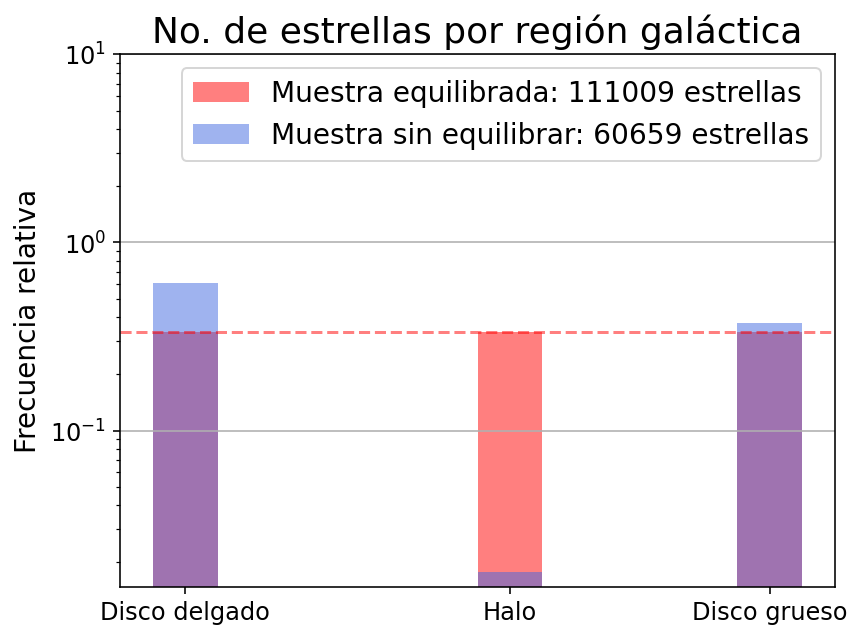

In [89]:
histogramas_region_galactica(modelo_1, equilibrado = True)

# 5. Definición de los árboles de decisión (``sklearn``) <a id="5"></a>

Los **árboles de decisión** son métodos de aprendizaje supervisado. Permiten identificar de forma automática el valor de una variable de interés (**variable endógena**) a partir de un conjunto de variables explicativas (**variables exógenas**).

Se distinguen **dos tipos de árboles de decisión**:
* **Árboles de clasificación:** permiten ajustar variables/relaciones **discretas**
* **Árboles de regresión:** permiten ajustar variables/relaciones **continuas**

Por otro lado, en un **árbol de decisión**, existen dos tipos de **nodos**:
* **Nodos internos:** representan atributos a partir de los cuales se realizan divisiones de los datos (incluyendo la raíz del árbol)
* **Nodoso terminales (u hojas):** entregan un valor ajustado para la variable de interés

Por ende, en los **árboles de decisión**, se realiza un proceso **iterativo**:
1. En cada **nodo**, se elige el mejor atributo para dividir
2. A partir de dicho atributo, se construyen **ramas a nuevos nodos**
3. Se dividen los registros de acuerdo al atributo para **generar dos nuevos nodos**
4. Repetir proceso

Además, existe el proceso de **Random Forest**, que básicamente consiste en hacer varios árboles de decisión y promediar sus resultados.

# 6. Árboles de clasificación <a id="6"></a>

## 6.a) Árbol de clasificación (``DecisionTreeClassifier``)

1. Como ahora se quieren buscar parámetros estelares que predigan la clasificación hecha anteriormente (**posición galáctica**), hay que descartar las columnas asociadas a dicha clasificación: ``vR_Rzphi``, ``vz_Rzphi``, ``vT_Rzphi``, ``mod_V``, ``pos_gal``, etc. Además, no se consideran los GALAH IDs.

2. Se divide la muestra en dos:
* **Muestra de entrenamiento:** 90% de las estrellas del catálogo equilibrado
* **Muestra de prueba:** 10% de las estrellas del catálogo equilibrado

3. Se calculan las métricas **Accuracy, Precision y Recall**.

4. Se muestra la **matriz de confusión**:
- **True Positive (TP):** Clase real: **Positivo** - Clase predicha: **Positivo**
- **False Positive (FP):** Clase real: **Negativo** - Clase predicha: **Positivo**
- **True Negative (TN):** Clase real: **Negativo** - Clase predicha: **Negativo**
- **False Negative (FN):** Clase real: **Positivo** - Clase predicha: **Negativo**

3. Se crea el **Decision Tree Classifier**.

In [90]:
def dividir_muestra(modelo: Modelo,
                    columna_target: str,
                   fraccion_datos_entrenamiento: float) -> tuple:
    """
    Divide la muestra equilibrada de estrellas asociada al MODELO, con un
    FRACCION_DATOS_ENTRENAMIENTO. El resto de los datos son para la muestra
    de prueba.
    Retorna una tupla con la muestra total, los datos de la columna target, y
    las muestras de entrenamiento y prueba.
    """
    # Para el modelo 1:
    if modelo.nombre == 'Modelo 1':
        # Catálogo:
        catalogo = modelo.catalogo_equilibrado

        # Se descartan las variables orbitales:
        columnas_a_descartar = ['sobject_id',
                                'mod_V', 'reg_gal',
                                'vR_Rzphi', 'vz_Rzphi', 'vT_Rzphi',
                                'R_Rzphi', 'z_Rzphi', 'phi_Rzphi',
                                'zmax',
                                'disco_delgado', 'disco_grueso', 'halo']

    # Para el modelo 2:
    elif modelo.nombre == 'Modelo 2':
        # Catálogo:
        catalogo = modelo.catalogo_clasificado

        # Se descartan el ID y los elementos alpha, ya que [Mg/Fe] es proxy de
        # estos elementos. También la clasificación:
        columnas_a_descartar = ['sobject_id',
                                'mod_V', 'reg_gal',
                                'mg_fe', 'si_fe', 'ca_fe', 'ti_fe',
                                'disco_delgado', 'disco_grueso', 'halo']

    # Clasificación de los datos:
    target = catalogo.copy()[[columna_target]]
    
    # Datos a usar para el árbol de decisión:
    data = catalogo.copy().drop(columns = columnas_a_descartar)

    # Seleccionar el porcentaje de las estrellas de la muestra que se usarán
    # para entrenamiento y prueba:
    porcentaje_datos_prueba = 1 - fraccion_datos_entrenamiento

    # Dividir la muestra:
    X_train, X_test, y_train, y_test = train_test_split(data, target,
                                    test_size = porcentaje_datos_prueba,
                                    random_state = np.random.randint(0, 2e8))

    return data, target, (X_train, X_test, y_train, y_test)

In [91]:
# Función para obtener algunas métricas de los árboles de decisión: 
def calcular_metricas(y_test: pd.DataFrame,
                      y_pred: pd.DataFrame,
                      clasificador: DecisionTreeClassifier,
                     columna_target: str,
                     graficar_matriz_confusion: bool = True) -> tuple:
    # Calcular e imprimir Accuracy, Precision y Recall:
    Accuracy = round(metrics.accuracy_score(y_test, y_pred), 3)
    Precision = round(metrics.precision_score(y_test, y_pred), 3)
    Recall = round(metrics.recall_score(y_test, y_pred), 3)

    print('- Métricas:')
    print("* Accuracy:", Accuracy)
    print("* Precision:", Precision)
    print("* Recall:", Recall)

    # Otras métricas:
    Depth = clasificador.get_depth()
    NLeaves = clasificador.get_n_leaves()
    Nodes = clasificador.tree_.node_count
    TerminalNodes = clasificador.tree_.node_count - clasificador.get_n_leaves()
    
    MaxFeatures = clasificador.max_features_
    NFeaturesIn = clasificador.n_features_in_
    FeaturesNames = clasificador.feature_names_in_

    # Calcular matriz de confusión:
    cm = metrics.confusion_matrix(y_test, y_pred, labels = clasificador.classes_,
                                  normalize = 'all')

    # Mostrar matriz de confusión:
    if graficar_matriz_confusion:
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                                display_labels = clasificador.classes_)
        disp.plot()
        
        # Parámetros del gráfico:
        disp.ax_.set_xlabel('Clase predicha', fontsize = 14)
        disp.ax_.set_ylabel('Clase real', fontsize = 14)

        nombre_columna = columna_target.replace('_', ' ')
        plt.title(f'Matriz de confusión: {nombre_columna}',
                fontsize = 18)

        plt.xticks(size = 12)
        plt.yticks(size = 12)

    return (Accuracy, Precision, Depth, NLeaves, Nodes, TerminalNodes,
            MaxFeatures, NFeaturesIn, FeaturesNames)

In [92]:
def arbol_de_decision(modelo: Modelo,
                      columna_target: str,
                      fraccion_datos_entrenamiento: float,
                      graficar_arbol: bool = False) -> None:
    # Dividir el catálogo en dos muestras: de entrenamiento y prueba
    data, _, muestras = dividir_muestra(modelo, columna_target,
                               fraccion_datos_entrenamiento)
    X_train, X_test, y_train, y_test = muestras
    
    # Crear objeto Decision Tree Classifier:
    clasificador = DecisionTreeClassifier(criterion = 'gini',
                                max_depth = 3,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                ccp_alpha = 0)

    # Entrenar Decision Tree Classifer
    clasificador = clasificador.fit(X_train, y_train)

    # Predecir respuesta para la muestra de prueba:
    y_pred = clasificador.predict(X_test)

    # Imprimir columna target:
    print('-.' * 50 + '-')
    print(f'- Columna target: {columna_target}\n')

    # Mostrar matriz de confusión:
    if graficar_arbol:
        graficar_matriz_confusion = True
    else:
        graficar_matriz_confusion = False
    calcular_metricas(y_test, y_pred, clasificador, columna_target,
                      graficar_matriz_confusion)
    print('-.' * 50 + '-')

    # Mostrar árbol de decisión:
    if graficar_arbol:
        dot_data = StringIO()

        nombre_clase = columna_target.replace('_', ' ').capitalize()
        export_graphviz(clasificador, out_file = dot_data, filled = True, rounded = True,
                    special_characters = True, feature_names = data.columns,
                    class_names = ['Otro', nombre_clase],
                    # class_names = True,
                    proportion = True, rotate = True)
        
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
        graph.write_png('Figuras/arbol_de_decision.jpg')
        fig = plt.figure(dpi = 210)
        img = mpimg.imread('Figuras/arbol_de_decision.jpg')
        imgplot = plt.imshow(img)
        plt.axis('off')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
- Columna target: disco_delgado

- Métricas:
* Accuracy: 0.771
* Precision: 0.647
* Recall: 0.689
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
- Columna target: disco_grueso

- Métricas:
* Accuracy: 0.675
* Precision: 0.517
* Recall: 0.272
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
- Columna target: halo

- Métricas:
* Accuracy: 0.854
* Precision: 0.732
* Recall: 0.867
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


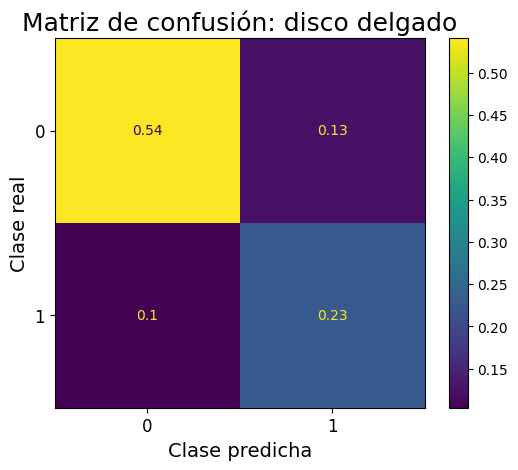

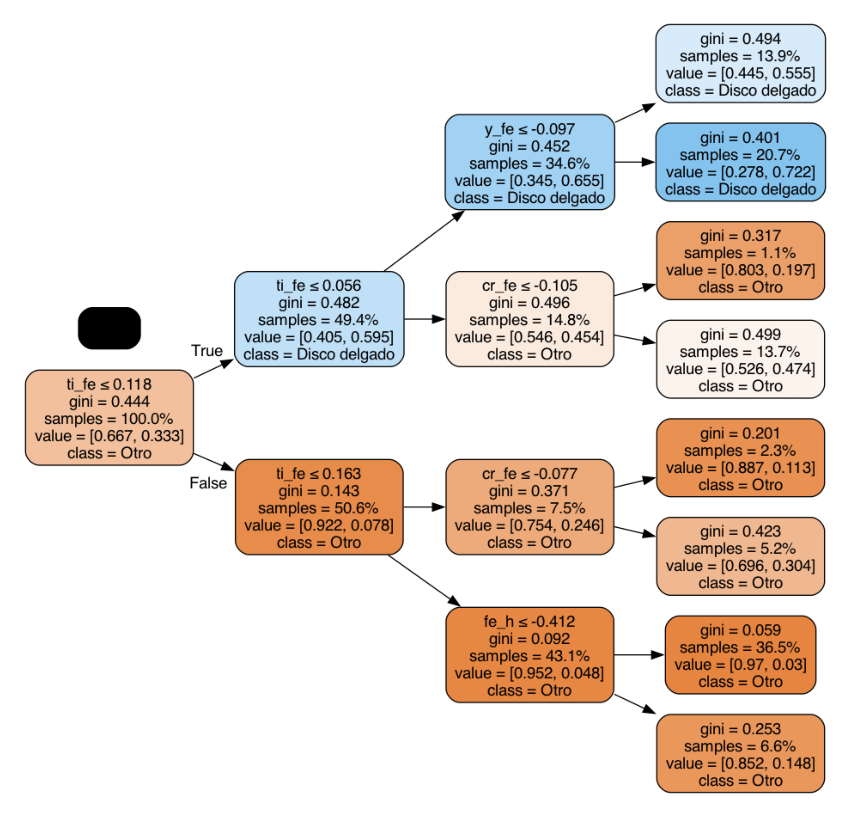

In [93]:
columnas_target = ['disco_delgado', 'disco_grueso', 'halo']

for contador, columna_target in enumerate(columnas_target):
    if contador == 0:
        graficar = True
    else:
        graficar = False
    arbol_de_decision(modelo = modelo_1,
                    columna_target = columna_target,
                    fraccion_datos_entrenamiento = 0.9,
                    graficar_arbol = graficar)

# 6.b) Random Forest de clasificación (``RandomForestClassifier``)

## 6.b.i) Maximizar *Precision* (minimizar falsos positivos FP)

Por otro lado, se calcularon **tres métricas**. Su definición es (ver Clase 21):
- **Accuracy:** comportamiento global del modelo.
\begin{align*}
\operatorname{Accuracy} \equiv \frac{\operatorname{TP} + \operatorname{TN}}{\operatorname{TP} + \operatorname{TN} + \operatorname{FP} + \operatorname{FN}}
\end{align*}

- **Precision:** capacidad de predecir la clase positiva ($\operatorname{TP}$ y $\operatorname{FP}$). Minimiza $\operatorname{FP}$.
\begin{align*}
\operatorname{Precision} \equiv \frac{\operatorname{TP}}{\operatorname{TP} + \operatorname{FP}}
\end{align*}

- **Recall:** habilidad del modelo de identificar todas las instancias positivas.
\begin{align*}
\operatorname{Recall} \equiv \frac{\operatorname{TP}}{\operatorname{TP} + \operatorname{FN}}
\end{align*}

Se elige **maximizar Precision**, es decir, **minimizar los Falsos Positivos (FP)**.

In [94]:
# Desactivar alertas de sklearn:
warnings.filterwarnings(action = 'ignore', category = DataConversionWarning)
warnings.filterwarnings(action = 'ignore', category = UndefinedMetricWarning)

In [95]:
def graficar_precision(modelo: Modelo,
                       numero_maximo_nodos_hijos: tuple,
                       fraccion_datos_entrenamiento: float = 0.9,
                       numero_de_arboles: int = 100,
                       mostrar_parametros: bool = False) -> None:
    """
    Graficar Precision como función de NUMERO_MAXIMO_NODOS_HIJOS, con
    NUMERO_DE_ARBOLES árboles de decisión por cada Random Forest. 
    """
    # Calcular 'Precision vs. No. máximo de nodos hijos para las regiones
    # galácticas:
    columnas_target = ['halo', 'disco_delgado', 'disco_grueso'] # Regiones
    precision_regiones = []
    max_depth_regiones = []
    
    for columna_target in columnas_target:
        # Dividir el catálogo en dos muestras: de entrenamiento y prueba
        _, _, muestras = dividir_muestra(modelo, columna_target,
                                   fraccion_datos_entrenamiento)
        X_train, X_test, y_train, y_test = muestras
    
        # Calcular Precision vs. No. máximo de nodos hijos:
        lista_precision = [] # Precision
        lista_max_depth = [] # No. máximo de nodos hijos
    
        nodos = numero_maximo_nodos_hijos[columna_target]
        for max_depth in np.arange(1, nodos + 1, 1):
            # Crear objeto Random Forest Classifer:
            clasificador = RandomForestClassifier(
                                        n_estimators = numero_de_arboles,
                                        criterion = 'gini',
                                        max_depth = max_depth,
                                        min_samples_split = 2,
                                        min_samples_leaf = 1,
                                        ccp_alpha = 0
                                        )
            
            # Entrenar objeto Random Forest Classifier:
            with parallel_backend('threading', n_jobs = 4):
                clasificador = clasificador.fit(X_train, y_train)
            
            # Predecir la respuesta con la muestra de prueba:
            y_pred = clasificador.predict(X_test)
    
            # Calcular Precision:
            precision = metrics.precision_score(y_test, y_pred)
    
            # Guardar el punto (Max_depth, Precision):
            lista_precision.append(precision)
            lista_max_depth.append(max_depth)

        # Guardar las listas de (Max_depth, Precision):
        precision_regiones.append(lista_precision)
        max_depth_regiones.append(lista_max_depth)

    # Crear figura:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 144)
    
    # Mostrar gráfico de Precision vs. No. máximo de nodos hijos:
    colores = ['orange', 'royalblue', 'green']
    estilos_lineas = ['-', '--', '-.']
    for indice in range(len(columnas_target)):
        # No. máximo de nodos hijos:
        lista_max_depth = max_depth_regiones[indice]

        # Precision:
        lista_precision = precision_regiones[indice]

        # Nombre de la región:
        columna_target = columnas_target[indice]
        nombre_columna = columna_target.replace('_', ' ').capitalize()

        # Graficar puntos:
        plt.plot(lista_max_depth, lista_precision,
                 color = colores[indice],
                 label = nombre_columna,
                    linestyle = estilos_lineas[indice])
    
    # Parámetros del gráfico:
    ## Título del gráfico:
    if mostrar_parametros:
        titulo = (f'fraccion_datos_entrenamiento = {fraccion_datos_entrenamiento}\n',
                f'numero_de_arboles = {numero_de_arboles}\n',
                f'numero_maximo_nodos_hijos = {numero_maximo_nodos_hijos}')
        plt.title(''.join(titulo), fontsize = 18)
    elif not mostrar_parametros:
        plt.title(f'Maximización de Precision', fontsize = 18)

    ## Límites del eje horizontal:
    x_max = max(tuple(numero_maximo_nodos_hijos.values()))
    xlims = (1., x_max, 4.)
    ax.set_xticks(np.arange(xlims[0], xlims[1], xlims[2]))
    plt.xlim([xlims[0], xlims[1]])

    ## Límites del eje vertical:
    ylims = (0., 1.1, 0.1)
    ax.set_yticks(np.arange(ylims[0], ylims[1], ylims[2]))
    plt.ylim([ylims[0], ylims[1]])
    
    ## Tamaños y nombres de los ejes:
    plt.ylabel('Precision', fontsize = 14)
    plt.xlabel('No. máximo de nodos hijos', fontsize = 14)
    
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    
    ## Otros:
    plt.grid()
    plt.legend(fontsize = 12)
    
    # Guardar figura:
    plt.savefig(f'Figuras/graficar_precision.jpg', bbox_inches = 'tight')

In [96]:
def mostrar_figura(ruta_archivo: str, dpi: int = 200) -> None:
    if path.exists(ruta_archivo):
        _, ax = plt.subplots(nrows = 1, ncols = 1, dpi = dpi)
        img = mpimg.imread(ruta_archivo)
        ax.imshow(img)
        plt.axis('off')
    else:
        raise 'Error: no existe el archivo en la ruta especificada.'

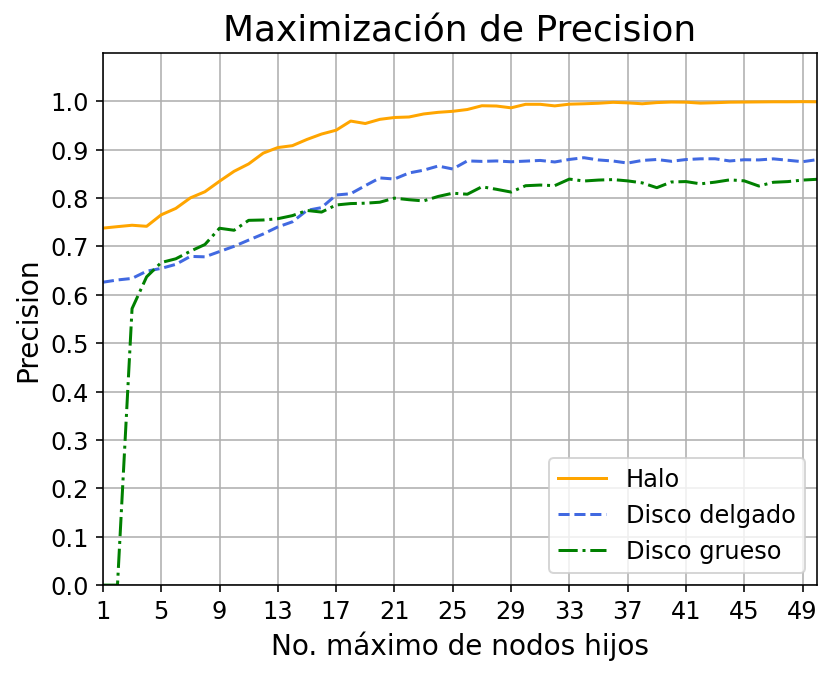

In [113]:
try:
    # Mostrar gráfico de Precision vs. no. máximo de nodos calculado
    # anteriormente:
    mostrar_figura(ruta_archivo = 'Figuras/graficar_precision.jpg', dpi = 200)

except:
    graficar_precision(modelo_1,
                        fraccion_datos_entrenamiento = 0.9,
                        numero_de_arboles = 10,
                        numero_maximo_nodos_hijos = {'halo': 50,
                                                    'disco_delgado': 50,
                                                    'disco_grueso': 50},
                        mostrar_parametros = False)

Se concluye que conviene usar distintos valores del **no. máximo de nodos hijos** para cada **región galáctica**, con tal de maximizar el valor de **Precision**:

1. **Disco delgado:** $\{\text{No. máximo de nodos hijos}\} = 31$

2. **Disco grueso:** $\{\text{No. máximo de nodos hijos}\} = 30$

3. **Halo:** $\{\text{No. máximo de nodos hijos}\} = 34$

In [98]:
# No. máximo de nodos hijos para cada región galáctica:
numero_nodos = {'disco_delgado': 31, 'disco_grueso': 30, 'halo': 34}

## 6.b.ii) Hacer Random Forest Classifier

Se hace un **Random Forest** para cada región galáctica. Esto permite distinguir los **atributos (columnas) importantes para la determinación de la región galáctica a la que pertenece una estrella**.

In [99]:
def clasificador_random_forest(modelo: Modelo,
                                columna_target: str,
                                fraccion_datos_entrenamiento: float,
                                numero_de_arboles: int,
                                numero_maximo_nodos_hijos: int) -> None:
    # Dividir el catálogo en dos muestras: de entrenamiento y prueba
    data, _, muestras = dividir_muestra(modelo, columna_target,
                                                fraccion_datos_entrenamiento)
    X_train, X_test, y_train, y_test = muestras

    # Crear objeto Random Forest Classifer:
    clasificador = RandomForestClassifier(n_estimators = numero_de_arboles,
                                criterion='gini',
                                max_depth = numero_maximo_nodos_hijos,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                ccp_alpha = 0)
    
    # Entrenar objeto Random Forest Classifer:
    with parallel_backend('threading', n_jobs = 4):
        clasificador = clasificador.fit(X_train, y_train)

    # Predecir la respuesta con la muestra de prueba:
    y_pred = clasificador.predict(X_test)

    # Calcular e imprimir las métricas:
    print('-.' * 50 + '-')
    print(f'- Columna target: {columna_target}\n')

    Accuracy = metrics.accuracy_score(y_test, y_pred)
    Precision = metrics.precision_score(y_test, y_pred)
    Recall = metrics.recall_score(y_test, y_pred)

    print("- Métricas:")
    print("* Accuracy:", Accuracy)
    print("* Precision:", Precision)
    print("* Recall:", Recall)
    print()

    # Calcular la importancia de cada columna usada en el Random Forest:
    ## Columnas usadas en el Random Forest:
    columnas = data.columns.tolist() 
    columnas = np.array(columnas)

    ## Importancias de las columnas (cuán importante es la columna para
    ## determinar la región galáctica de una estrella):
    importancias = clasificador.feature_importances_

    print('- Columnas usadas y sus importancias (3 cifras decimales):')
    print(columnas, np.around(importancias, 3), sep = '\n')

    # Ordenar columnas según su importancia (descendente):
    columnas = columnas[np.argsort(importancias)[::-1]]
    importancias = importancias[np.argsort(importancias)[::-1]]

    # Imprimir las columnas con mayor importancia:
    print('\n- Columnas más importantes:')
    numero_columnas_importantes = 3
    for i in range(numero_columnas_importantes):
        # if round(importancias[i], 1) > 0:
        print(columnas[i], round(importancias[i], 3))
    print('-.' * 50 + '-')

Los parámetros relevantes en la función ``clasificador_random_forest`` son:
- ``fraccion_datos_entrenamiento = 0.9``: como antes, se usa el **90% de los datos para entrenamiento**, y el 10% restante para prueba.

- ``numero_de_arboles = 200``: se calculan **200 árboles en cada Random Forest**, es decir, para cada región galáctica.

- ``numero_maximo_nodos_hijos``: se usan los valores definidos anteriormente.

Entonces:
1. Se divide la muestra en la proporción indicada por ``fraccion_datos_entrenamiento``, con la función ``dividir_muestra``.

2. Se calcula el clasificador con ``sklearn.ensemble.RandomForestClassifier``:
- ``criterion = gini``: criterio de clasificación
- ``n_estimators``: número de árboles de decisión
- ``max_depth``: número máximo de nodos hijos
-  ``min_samples_split = 2``: número mínimo de muestras necesarias para dividir un nodo interno
- ``min_samples_leaf = 1``: número mínimo de muestras necesarias para que el nodo sea una hoja
- ``ccp_alpha = 0``: no hacer *pruning*

3. 

In [100]:
for columna_target in ['disco_delgado', 'disco_grueso', 'halo']:
    clasificador_random_forest(modelo = modelo_1,
                    columna_target = columna_target,
                    fraccion_datos_entrenamiento = 0.9,
                    numero_de_arboles = 200,
                    numero_maximo_nodos_hijos = numero_nodos[columna_target])

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
- Columna target: disco_delgado

- Métricas:
* Accuracy: 0.9031618773083506
* Precision: 0.8723221936589546
* Recall: 0.8294405214557306

- Columnas usadas y sus importancias (3 cifras decimales):
['teff' 'fe_h' 'vmic' 'vsini' 'mass' 'age' 'lbol' 'mg_fe' 'si_fe' 'ca_fe'
 'ti_fe' 'c_fe' 'n_fe' 'o_fe' 'na_fe' 'al_fe' 'k_fe' 'sc_fe' 'v_fe'
 'cr_fe' 'mn_fe' 'co_fe' 'ni_fe' 'cu_fe' 'zn_fe' 'rb_fe' 'sr_fe' 'y_fe'
 'zr_fe' 'mo_fe' 'ba_fe' 'la_fe' 'ce_fe' 'nd_fe' 'ru_fe' 'sm_fe' 'eu_fe'
 'g']
[0.024 0.058 0.017 0.017 0.032 0.022 0.023 0.075 0.056 0.04  0.102 0.016
 0.018 0.035 0.018 0.017 0.027 0.021 0.022 0.023 0.033 0.018 0.018 0.017
 0.015 0.015 0.015 0.029 0.019 0.016 0.018 0.019 0.016 0.016 0.016 0.016
 0.015 0.024]

- Columnas más importantes:
ti_fe 0.102
mg_fe 0.075
fe_h 0.058
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
-.-.-.-.-

Resulta que las **tres variables más importantes** para predecir la región galáctica son:

- **Disco delgado y halo:** $\operatorname{[Fe/H]}$, $\operatorname{[Ti/Fe]}$ y $\operatorname{[Mg/Fe]}$
- **Disco grueso:** $\operatorname{[Fe/H]}$, $\operatorname{[Ti/Fe]}$ e $\operatorname{[Y/Fe]}$

## 6.c) Graficar correlaciones entre atributos

In [101]:
def graficar_columnas_kdeplot(modelo: Modelo,
                      columna_x: str,
                      columnas_y: tuple[str],
                      xlims: tuple[float, float, float] = None,
                      prueba_reducida: bool = False,
                      numero_de_niveles: int = 5) -> None:
    
    # Catálogo equilibrado:
    if prueba_reducida:
        # Prueba reducida: 1000 estrellas
        catalogo = modelo.catalogo_equilibrado.head(1000)
    else:
        catalogo = modelo.catalogo_equilibrado

    # Crear figura:
    fig, ax = plt.subplots(nrows = len(columnas_y), 
                           ncols = 1, figsize = (5, 10))
    plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.1, 
                    hspace = 0.0001)

    # Gráficos:
    for contador, columna_y in enumerate(columnas_y):
        # Hacer gráfico de contornos de densidad:
        sns.kdeplot(data = catalogo,
                        x = columna_x,
                        y = columna_y,
                        hue = 'reg_gal',
                        levels = numero_de_niveles,
                        legend = False,
                        ax = ax[contador])
        
        # Esconder el eje horizontal:
        if contador < (len(columnas_y) - 1):
            ax[contador].get_xaxis().set_visible(False)

        # Nombre de la columna vertical:
        nombre_y, unidades_y = modelo.info_columnas[columna_y]

        # Nombre del eje vertical:
        if unidades_y:
            ax[contador].set_ylabel(nombre_y + f'{unidades_y}', fontsize = 14)
        else:
            ax[contador].set_ylabel(nombre_y, fontsize = 14)
        ax[contador].tick_params(axis = 'y', labelsize = 14)
    
    # Eje horizontal:
    ## Nombre de la columna horizontal:
    nombre_x, unidades_x = modelo.info_columnas[columna_x]

    ## Nombre del eje horizontal:
    if unidades_x:
        plt.xlabel(nombre_x + f'{unidades_x}', fontsize = 14)
    else:
        plt.xlabel(nombre_x, fontsize = 14)

    ## Límites del eje horizontal:
    if xlims:
        plt.xlim([xlims[0], xlims[1]])
        for eje in ax:
            eje.set_xticks(np.arange(xlims[0], xlims[1], xlims[2]))

    # Leyenda:
    lineas = [Line2D([0], [0], color = 'royalblue', lw = 4),
                Line2D([0], [0], color= 'orange', lw = 4),
                Line2D([0], [0], color = 'green', lw = 4)]
    ax[0].legend(lineas, ['Disco delgado', 'Halo', 'Disco grueso'],
                 fontsize = 14, ncol = 3,
                 bbox_to_anchor = (1.2, 1.3))
    
    # Otros:
    plt.xticks(size = 14)
    plt.yticks(size = 14)

    # Guardar figura:
    if not prueba_reducida:
        plt.savefig(f'Figuras/correlaciones_{columna_x}.jpg',
                    bbox_inches = 'tight')

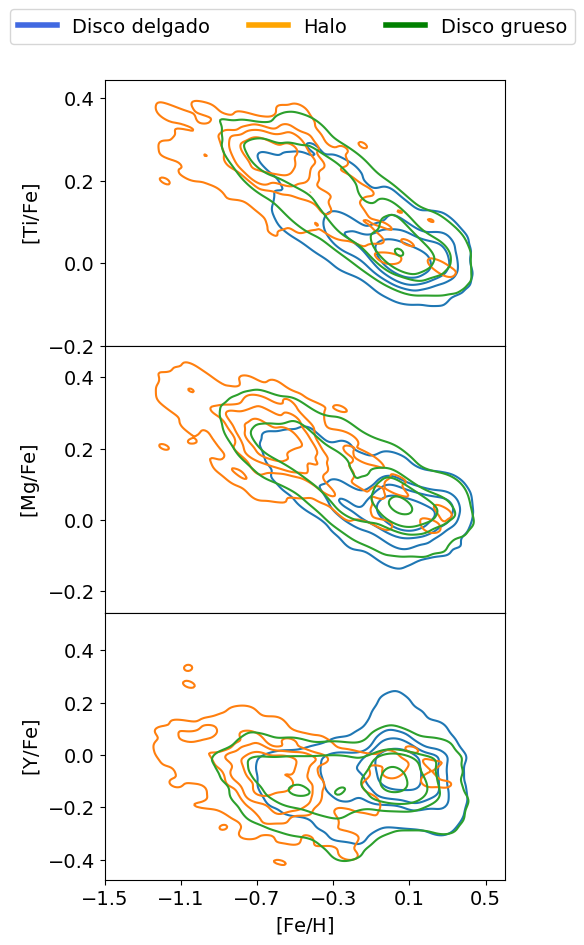

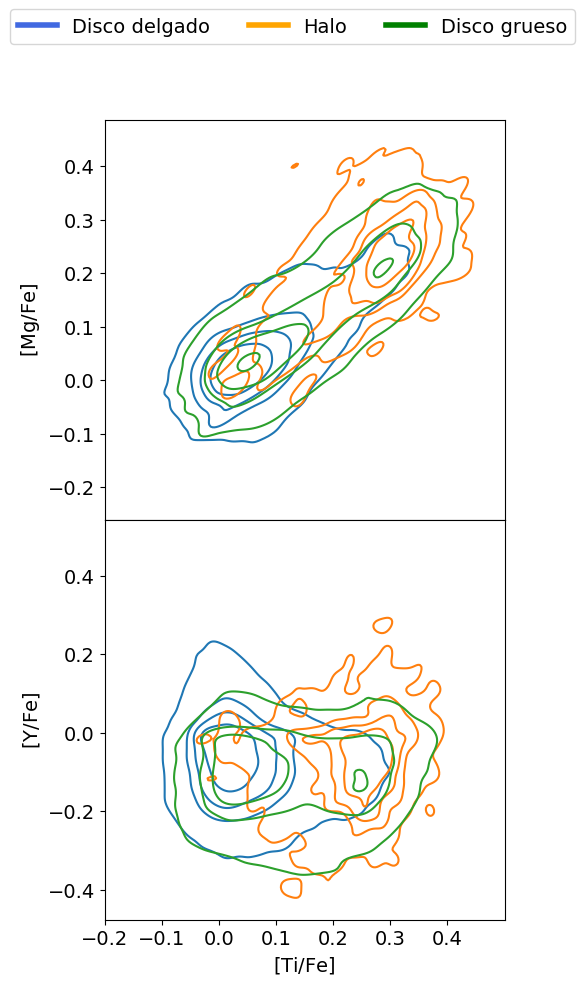

In [102]:
# Correlaciones de [Fe/H]:
try:
    mostrar_figura(ruta_archivo = 'Figuras/correlaciones_fe_h.jpg', dpi = 300)
except:
    graficar_columnas_kdeplot(modelo_1,
                    columna_x = 'fe_h',
                    columnas_y = ('ti_fe', 'mg_fe', 'y_fe'),
                    xlims = (-1.5, 0.6, 0.4),
                    prueba_reducida = False,
                    numero_de_niveles = 5)

# Correlaciones de [Ti/Fe]:
try:
    mostrar_figura(ruta_archivo = 'Figuras/correlaciones_ti_fe.jpg', dpi = 300)
except:
    graficar_columnas_kdeplot(modelo_1,
                    columna_x = 'ti_fe',
                    columnas_y = ('mg_fe', 'y_fe'),
                    xlims = (-0.2, 0.5, 0.1),
                    prueba_reducida = False,
                    numero_de_niveles = 5)

Se aprecia una **separación significativa** entre las poblaciones estelares del **halo** y las del **disco galáctico**, para las abundancias seleccionadas.

Por otro lado, existe una diferencia menor entre las poblaciones del **disco delgado** y el **disco grueso**. Esto significa que, **si bien es posible diferenciar ambas poblaciones en ciertos rangos de abundancias químicas, hay bastante solapamiento entre dichas poblaciones estelares**.

# 7. Árboles de regresión <a id="7"></a>

## 7.a) Crear nuevo modelo

Se crea el **Modelo 2** para predecir la abundancia de magnesio $\operatorname{[Mg/Fe]}$ (variable continua) a partir de los parámetros conocidos.

In [103]:
modelo_2 = Modelo(nombre = 'Modelo 2',
                columnas_catalogo_1 = ('sobject_id', 'teff', 'logg', 'fe_h',
                                        'vmic', 'vsini',
                                        'mass', 'age', 'lbol',
                                        'mg_fe', 'si_fe', 'ca_fe', 'ti_fe',
                                        'c_fe', 'n_fe', 'o_fe',
                                        'na_fe', 'al_fe', 'k_fe',
                                        'sc_fe', 'v_fe', 'cr_fe', 'mn_fe',
                                        'co_fe', 'ni_fe', 'cu_fe', 'zn_fe',
                                        'rb_fe', 'sr_fe', 'y_fe', 'zr_fe',
                                        'mo_fe', 'ba_fe', 'la_fe', 'ce_fe',
                                        'nd_fe',
                                        'ru_fe', 'sm_fe', 'eu_fe'),
                columnas_catalogo_3 = ('sobject_id',
                                       'R_Rzphi', 'z_Rzphi', 'phi_Rzphi',
                                       'vR_Rzphi', 'vz_Rzphi', 'vT_Rzphi',
                                       'zmax'))

In [104]:
# Copiar el catálogo y la información de las columnas del modelo 1:
modelo_2.catalogo_clasificado = modelo_1.catalogo_clasificado.copy()
modelo_2.info_columnas = modelo_1.info_columnas

In [105]:
modelo_2.catalogo_clasificado.head(5)

sobject_id         teff      fe_h      vmic     vsini      mass  \
0  140811005001160  4819.867188  0.156381  1.214888  2.498944  1.161967   
1  170910004101289  4366.514160 -0.565017  1.849028  6.531576  1.003146   
2  170828002701216  3893.883789 -0.713241  1.593353  5.745141  0.874649   
3  150828004701010  4670.961426  0.169911  1.352055  1.843184  1.371182   
4  170711005801306  4037.070068 -0.562671  1.592211  3.740058  0.943281   

         age        lbol     mg_fe     si_fe  ...    vR_Rzphi   vz_Rzphi  \
0   7.264210    9.799262  0.009314  0.027905  ...   16.278175 -14.997689   
1   8.639011  146.775955  0.145063  0.166607  ...   60.378155   6.996849   
2  10.409679  553.885681  0.177635  0.302454  ...   61.444614 -30.529341   
3   4.363142   29.451641  0.024736  0.047790  ...   33.301712  45.289707   
4  10.207219  321.647125  0.191233  0.318600  ... -107.884804  20.743784   

     vT_Rzphi      zmax            g       mod_V  disco_delgado  disco_grueso  \
0  246.709259  0.828761  1580.648804   23.128420              1             0   
1   52.205936  4.735855    61.368214  197.385632              0             0   
2  206.434921  1.805653     8.966853   76.381253              0             1   
3  192.420532  1.505263   547.401001   73.647589              0             1   
4  245.909363  3.313861    19.240713  110.019798              0             1   

   halo        reg_gal  
0     0  Disco delgado  
1     1           Halo  
2     0   Disco grueso  
3     0   Disco grueso  
4     0   Disco grueso  

[5 rows x 51 columns]

## 7.b) Minimizar errores (métrica $\operatorname{RMSE}$)

Existen múltiples métricas que miden los errores en los árboles de regresión. Dos de ellas son:

1. El **coeficiente de determinación** (o **score**) $R^2$:

\begin{align*}
R^2 \equiv 1 - \frac{\sum_i^n (y_{\mathrm{true},i} - y_{\mathrm{pred},i})^2}{\sum_i^n (y_{\mathrm{true},i} - \overline{y_{\mathrm{true},i}})^2}
\end{align*}

2. El **root mean squared error** $\operatorname{RMSE}$:
\begin{align*}
\operatorname{RMSE} \equiv \sqrt{\frac{\sum_i^n (y_{\mathrm{true},i} - y_{\mathrm{pred},i})^2}{n}}
\end{align*}

- $y_{\mathrm{true,i}}$: $i$-ésimo dato observado
- $y_{\mathrm{pred,i}}$: $i$-ésimo dato predicho
- $n$: número total de datos

Arbitrariamente, se elige minimizar el $\operatorname{RMSE}$.

In [106]:
def graficar_rmse(modelo: Modelo,
                  columna_target: str,
                       numero_maximo_nodos_hijos: tuple,
                       fraccion_datos_entrenamiento: float = 0.9,
                       numero_de_arboles: int = 100,
                       mostrar_parametros: bool = False) -> None:
    """
    Graficar RMSE como función de NUMERO_MAXIMO_NODOS_HIJOS, con
    NUMERO_DE_ARBOLES árboles de decisión por cada Random Forest. 
    """
    # Dividir el catálogo en dos muestras: de entrenamiento y prueba
    _, _, muestras = dividir_muestra(modelo, columna_target,
                                fraccion_datos_entrenamiento)
    X_train, X_test, y_train, y_test = muestras

    # Calcular RMSE vs. No. máximo de nodos hijos:
    lista_rmse = [] # RMSE
    lista_max_depth = [] # No. máximo de nodos hijos

    for max_depth in np.arange(1, numero_maximo_nodos_hijos + 1, 1):
        # Crear objeto Random Forest Regressor:
        regresion = RandomForestRegressor(
                                    n_estimators = numero_de_arboles,
                                    criterion = 'squared_error',
                                    max_depth = max_depth,
                                    min_samples_split = 2,
                                    min_samples_leaf = 1,
                                    ccp_alpha = 0
                                    )
        
        # Entrenar objeto Random Forest Regressor:
        with parallel_backend('threading', n_jobs = 6):
            regresion = regresion.fit(X_train, y_train)
        
        # Predecir la respuesta con la muestra de prueba:
        y_pred = regresion.predict(X_test)

        # Calcular RMSE:
        rmse = root_mean_squared_error(y_test, y_pred)

        # Guardar el punto (Max_depth, Precision):
        lista_rmse.append(rmse)
        lista_max_depth.append(max_depth)

    # Crear figura:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 144)
    
    # Mostrar gráfico de RMSE vs. No. máximo de nodos hijos:
    ## Nombre de la columna target:
    nombre_columna = modelo.info_columnas[columna_target][0]

    ## Graficar puntos:
    plt.plot(lista_max_depth, lista_rmse, color = 'blueviolet', label = nombre_columna)
    
    # Parámetros del gráfico:
    ## Título del gráfico:
    if mostrar_parametros:
        titulo = (f'fraccion_datos_entrenamiento = {fraccion_datos_entrenamiento}\n',
                f'numero_de_arboles = {numero_de_arboles}\n',
                f'numero_maximo_nodos_hijos = {numero_maximo_nodos_hijos}')
        plt.title(''.join(titulo), fontsize = 18)
    elif not mostrar_parametros:
        plt.title(f'Minimización de RMSE', fontsize = 18)

    ## Límites del eje horizontal:
    xlims = (1., numero_maximo_nodos_hijos, 3.)
    ax.set_xticks(np.arange(xlims[0], xlims[1], xlims[2]))
    plt.xlim([xlims[0], xlims[1]])

    ## Límites del eje vertical:
    #ylims = (0., 1.1, 0.1)
    #ax.set_yticks(np.arange(ylims[0], ylims[1], ylims[2]))
    #plt.ylim([ylims[0], ylims[1]])
    
    ## Tamaños y nombres de los ejes:
    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('No. máximo de nodos hijos', fontsize = 14)
    
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    
    ## Otros:
    plt.grid()
    plt.legend(fontsize = 12)
    
    # Guardar figura:
    plt.savefig(f'Figuras/graficar_rmse.jpg', bbox_inches = 'tight')

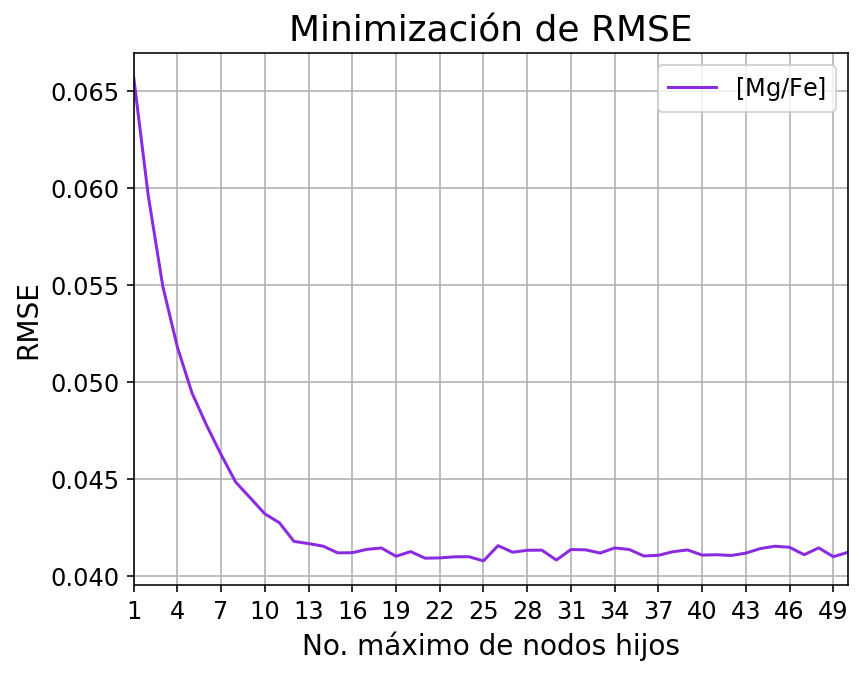

In [112]:
try:
    # Mostrar gráfico de RMSE vs. no. máximo de nodos calculado
    # anteriormente:
    mostrar_figura(ruta_archivo = 'Figuras/graficar_rmse.jpg', dpi = 200)

except:
    graficar_rmse(modelo_2,
                  columna_target = 'mg_fe',
                        fraccion_datos_entrenamiento = 0.9,
                        numero_de_arboles = 10,
                        numero_maximo_nodos_hijos = 50,
                        mostrar_parametros = False)

Para el $\operatorname{[Mg/Fe]}$, se minimiza **RMSE** con $\{\text{No. máximo de nodos hijos}\} = 19$.

## 7.c) Random Forest de regresión (``RandomForestRegressor``)

Para determinar cuáles parámetros predicen mejor la abundancia de magnesio $\operatorname{[Mg/Fe]}$, se realiza un **Random Forest de regresión** (variable continua):

In [108]:
def regresion_random_forest(modelo: Modelo,
                                columna_target: str,
                                fraccion_datos_entrenamiento: float,
                                numero_de_arboles: int,
                                numero_maximo_nodos_hijos: int) -> None:
    # Dividir el catálogo en dos muestras: de entrenamiento y prueba
    data, _, muestras = dividir_muestra(modelo, columna_target,
                                                fraccion_datos_entrenamiento)
    X_train, X_test, y_train, y_test = muestras

    # Crear objeto Random Forest Regressor:
    regresion = RandomForestRegressor(n_estimators = numero_de_arboles,
                                criterion = 'squared_error',
                                max_depth = numero_maximo_nodos_hijos,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                ccp_alpha = 0)
    
    # Entrenar objeto Random Forest Regressor:
    with parallel_backend('threading', n_jobs = 6):
        regresion = regresion.fit(X_train, y_train)

    # Predecir la respuesta con la muestra de prueba:
    y_pred = regresion.predict(X_test)

    # Calcular e imprimir las métricas:
    print('-.' * 50 + '-')
    print(f'- Columna target: {columna_target}\n')

    R_squared = regresion.score(X_test, y_test)
    RMS_error = root_mean_squared_error(y_test, y_pred)

    print("- Métricas:")
    print("* Coeficiente de determinación R^2:", R_squared)
    print("* Root Mean Squared Error:", RMS_error)
    print()

    # Calcular la importancia de cada columna usada en el Random Forest:
    ## Columnas usadas en el Random Forest:
    columnas = data.columns.tolist() 
    columnas = np.array(columnas)
    
    ## Importancias de las columnas (cuán importante es la columna para
    ## determinar la región galáctica de una estrella):
    importancias = regresion.feature_importances_

    print('- Columnas usadas y sus importancias (3 cifras decimales):')
    print(columnas, np.around(importancias, 3), sep = '\n')

    # Ordenar columnas según su importancia (descendente):
    columnas = columnas[np.argsort(importancias)[::-1]]
    importancias = importancias[np.argsort(importancias)[::-1]]

    # Imprimir las columnas con mayor importancia:
    print('\n- Columnas más importantes:')
    numero_columnas_importantes = 3
    for i in range(numero_columnas_importantes):
        # if round(importancias[i], 1) > 0:
        print(columnas[i], round(importancias[i], 3))
    print('-.' * 50 + '-')

Se usa ``numero_maximo_nodos_hijos = 19`` para el **Random Forest Regression**.

In [109]:
regresion_random_forest(modelo = modelo_2,
                    columna_target = 'mg_fe',
                    fraccion_datos_entrenamiento = 0.9,
                    numero_de_arboles = 200,
                    numero_maximo_nodos_hijos = 19)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
- Columna target: mg_fe

- Métricas:
* Coeficiente de determinación R^2: 0.8133231406851399
* Root Mean Squared Error: 0.03882781951802079

- Columnas usadas y sus importancias (3 cifras decimales):
['teff' 'fe_h' 'vmic' 'vsini' 'mass' 'age' 'lbol' 'c_fe' 'n_fe' 'o_fe'
 'na_fe' 'al_fe' 'k_fe' 'sc_fe' 'v_fe' 'cr_fe' 'mn_fe' 'co_fe' 'ni_fe'
 'cu_fe' 'zn_fe' 'rb_fe' 'sr_fe' 'y_fe' 'zr_fe' 'mo_fe' 'ba_fe' 'la_fe'
 'ce_fe' 'nd_fe' 'ru_fe' 'sm_fe' 'eu_fe' 'R_Rzphi' 'z_Rzphi' 'phi_Rzphi'
 'vR_Rzphi' 'vz_Rzphi' 'vT_Rzphi' 'zmax' 'g']
[0.028 0.565 0.007 0.004 0.005 0.01  0.007 0.006 0.009 0.008 0.022 0.014
 0.004 0.09  0.02  0.008 0.034 0.031 0.008 0.01  0.005 0.006 0.006 0.006
 0.006 0.005 0.008 0.006 0.006 0.006 0.004 0.005 0.005 0.005 0.003 0.003
 0.003 0.003 0.004 0.007 0.009]

- Columnas más importantes:
fe_h 0.565
sc_fe 0.09
mn_fe 0.034
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Por ende, las **abundancias más importantes en la predicción de $\operatorname{[Mg/Fe]}$ son $\operatorname{[Fe/H]}$, $\operatorname{[Sc/Fe]}$ y $\operatorname{[Mn/Fe]}$**.

## 7.d) Gráficos de correlación con $\operatorname{[Mg/Fe]}$: predicción de la región galáctica y la edad estelar

In [110]:
def graficar_columnas_scatter(modelo: Modelo,
                      columna_x: str,
                      columnas_y: tuple[str],
                      xlims: tuple[float, float, float] = None,
                    ylims: list[tuple[float, float, float]] = None,
                        numero_de_niveles: int = 5,
                             prueba_reducida: bool = False) -> None:
    
    # Catálogo:
    if modelo.nombre == 'Modelo 2':
        if prueba_reducida:
            # Prueba reducida: 1000 estrellas
            catalogo = modelo.catalogo_clasificado.head(1000)
        else:
            catalogo = modelo.catalogo_clasificado

    # Crear figura:
    fig, ax = plt.subplots(nrows = len(columnas_y), 
                           ncols = 2, figsize = (10, 20))
    plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.1, 
                    hspace = 0.05)

    # Gráficos:
    for contador, columna_y in enumerate(columnas_y):
        # Izquierda: gráfico de contornos de densidad según región galáctica
        sns.kdeplot(data = catalogo,
                        x = columna_x,
                        y = columna_y,
                        hue = 'reg_gal',
                        levels = numero_de_niveles,
                        legend = False,
                        ax = ax[contador][0])
        
        # Derecha: scatter según edad estelar
        ## Hacer scatterplot:
        sns.scatterplot(data = catalogo,
                    x = columna_x,
                    y = columna_y,
                       ax = ax[contador][1],
                    hue = 'age',
                    palette = 'viridis')

        ## Normalizar colormap:
        norm = plt.Normalize(catalogo['age'].min(), catalogo['age'].max())
        sm = plt.cm.ScalarMappable(cmap = 'viridis', norm = norm)
        sm.set_array([])

        ## Esconder leyenda;
        ax[contador][1].get_legend().remove()

        ## Agregar colorbar:
        cbar = fig.colorbar(sm, ax = ax[contador][1])
        cbar.ax.tick_params(labelsize = 12)
        cbar.set_label(r'Edad estelar ($Gyr$)', fontsize = 14)
        
        
        # Esconder eje horizontal:
        if contador < (len(columnas_y) - 1):
            ax[contador][0].get_xaxis().set_visible(False)
            ax[contador][1].get_xaxis().set_visible(False)

        # Esconder eje vertical de los gráficos de la derecha:
        ax[contador][1].get_yaxis().set_visible(False)

        # Nombre de la columna vertical:
        nombre_y, unidades_y = modelo.info_columnas[columna_y]

        # Nombre del eje vertical:
        if unidades_y:
            ax[contador][0].set_ylabel(nombre_y + f'{unidades_y}', fontsize = 14)
        else:
            ax[contador][0].set_ylabel(nombre_y, fontsize = 14)

        # Tamaño de los ticks:
        ax[contador][0].tick_params(axis = 'y', labelsize = 14)
        ax[contador][0].tick_params(axis = 'x', labelsize = 14)
        ax[contador][1].tick_params(axis = 'x', labelsize = 14)
    
    # Eje horizontal:
    ## Nombre de la columna horizontal:
    nombre_x, unidades_x = modelo.info_columnas[columna_x]

    ## Nombre del eje horizontal:
    if unidades_x:
        ax[contador][0].set_xlabel(nombre_x + f'{unidades_x}', fontsize = 14)
        ax[contador][1].set_xlabel(nombre_x + f'{unidades_x}', fontsize = 14)
    else:
        ax[contador][0].set_xlabel(nombre_x, fontsize = 14)
        ax[contador][1].set_xlabel(nombre_x, fontsize = 14)

    # Leyenda:
    lineas = [Line2D([0], [0], color = 'royalblue', lw = 4),
                Line2D([0], [0], color= 'orange', lw = 4),
                Line2D([0], [0], color = 'green', lw = 4)]
    ax[0][0].legend(lineas, ['Disco delgado', 'Halo', 'Disco grueso'],
                 bbox_to_anchor = (1.8, 1.1), fontsize = 14, ncol = 3)

    # Límites de los ejes:
    no_filas = len(columnas_y) # Número de filas
    if xlims:
        for indice_fila in range(no_filas):
            for indice_columna in (0, 1):
                ax[indice_fila][indice_columna].set_xlim([xlims[0], xlims[1]])
                ax[indice_fila][indice_columna].set_xticks(np.arange(xlims[0], xlims[1], xlims[2]))

    if ylims:
        for indice_fila in range(no_filas):
            for indice_columna in (0, 1):
                ylim = ylims[indice_fila]
                ax[indice_fila][indice_columna].set_ylim([ylim[0], ylim[1]])
                ax[indice_fila][indice_columna].set_yticks(np.arange(ylim[0], ylim[1], ylim[2]))
    
    # Otros:
    plt.xticks(size = 14)
    plt.yticks(size = 14)

    # Guardar figura:
    if not prueba_reducida:
        plt.savefig(f'Figuras/correlaciones_{columna_x}.jpg', bbox_inches = 'tight')

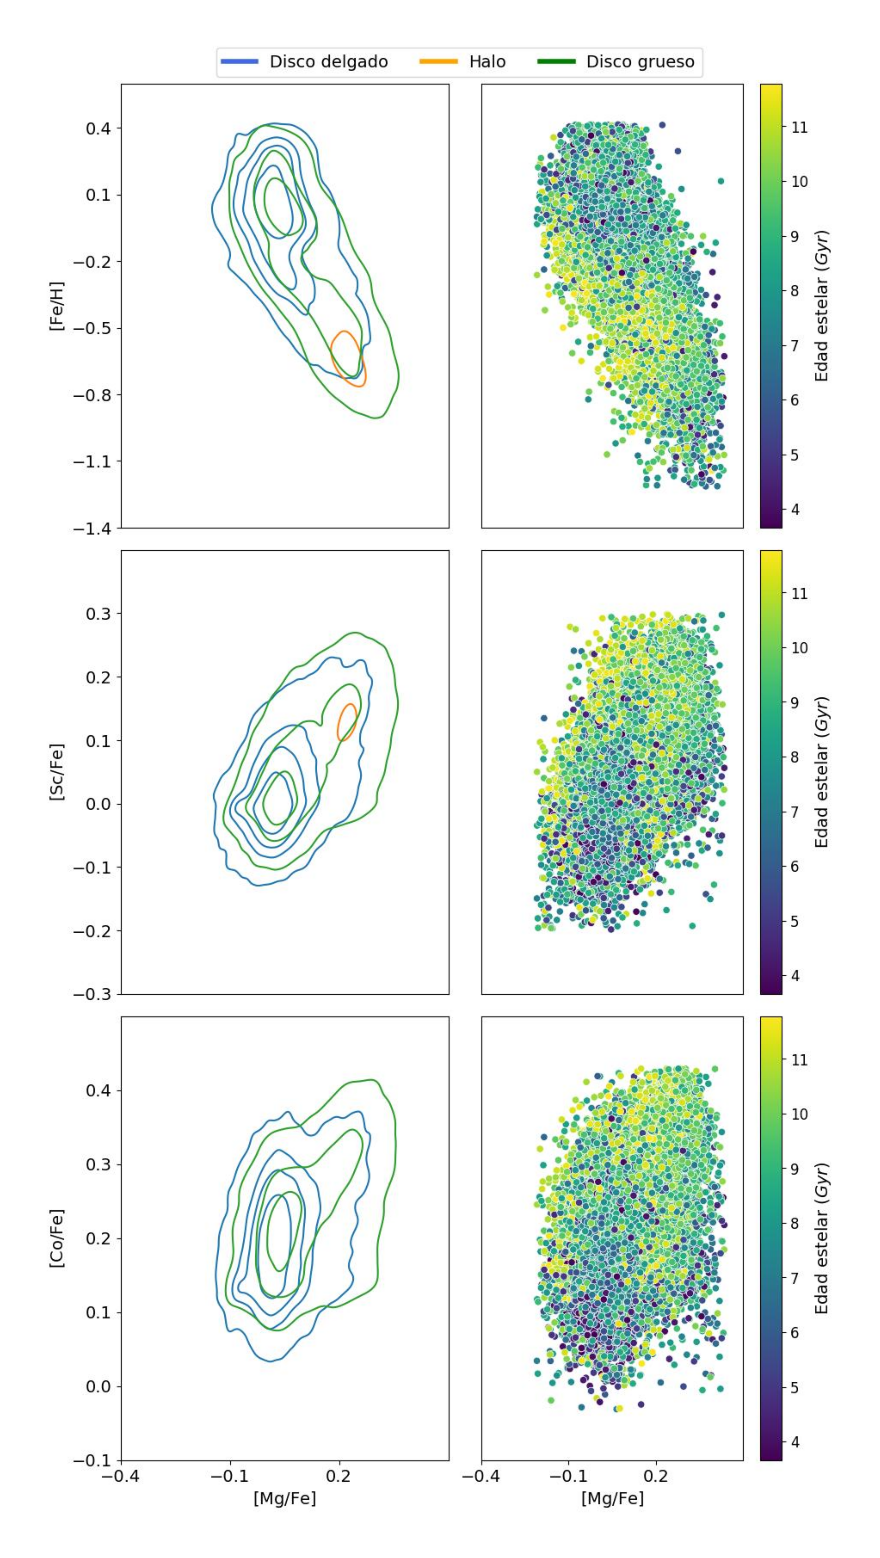

In [111]:
# Correlaciones de [Mg/Fe]:
try:
    mostrar_figura(ruta_archivo = 'Figuras/correlaciones_mg_fe.jpg', dpi = 400)
except:
    graficar_columnas_scatter(modelo_2,
                    columna_x = 'mg_fe',
                    columnas_y = ('fe_h', 'sc_fe', 'co_fe'),
                    xlims = (-0.4, 0.5, 0.3),
                    ylims = [(-1.4, 0.6, 0.3),
                             (-0.3, 0.4, 0.1),
                             (-0.1, 0.5, 0.1)],
                    numero_de_niveles = 5,
                    prueba_reducida = False)

1. Los gráficos de la izquierda distinguen la **región galáctica** a la que pertenecen las estrellas. Se aprecian leves diferencias entre las distribuciones de estrellas de diferentes regiones.

* Por ende, $\operatorname{[Mg/Fe]}$ en conjunto con $\operatorname{[Fe/H]}$, $\operatorname{[Sc/Fe]}$ y $\operatorname{[Co/Fe]}$ permitiría -al menos- diferenciar estrellas entre los **discos delgado y grueso**.

* En cambio, la distribución de estrellas del **halo** parece estar sumamente concentrada en rangos de abundancias coincidentes con estrellas de otras regiones. Por lo anterior, estas abundancias no resultan ser buenos predictores de la región galáctica cuando se trata de estrellas del **halo**.

2. Los gráficos de la derecha distinguen la **edad estelar**.
* **$\operatorname{[Mg/Fe]}$ vs. $\operatorname{[Fe/H]}$:** las **estrellas más viejas** se distribuyen casi uniformemente, mientras que las **estrellas más jovenes** se concentran hacia menores valores de $\operatorname{[Mg/Fe]}$ y $\operatorname{[Fe/H]}$.
* **$\operatorname{[Mg/Fe]}$ vs. $\operatorname{[Sc/Fe]}$:** las **estrellas más viejas** se concentran hacia menores valores de $\operatorname{[Sc/Fe]}$, pero distribuidas en todo el rango de $\operatorname{[Mg/Fe]}$. En cambio, las **estrellas más jóvenes** se concentran hacia mayores valores de $\operatorname{[Sc/Fe]}$ y menores valores de $\operatorname{[Mg/Fe]}$.
* **$\operatorname{[Mg/Fe]}$ vs. $\operatorname{[Co/Fe]}$:** comportamiento extremadamente similar a $\operatorname{[Mg/Fe]}$ vs. $\operatorname{[Sc/Fe]}$.

# Referencias bibliográficas

[1] da Silva, M. P., de Lima, M. M. F., Velloso, E. N., and do Nascimento, J.-D., “Nonextensive Behavior of Stellar Rotation in the Galactic Disk Components”, <i>The Astrophysical Journal</i>, vol. 958, no. 1, Art. no. 32, IOP, 2023. doi:10.3847/1538-4357/acfc3f.

[2] Gaia Collaboration, “Gaia Data Release 2. Mapping the Milky Way disc kinematics”, <i>Astronomy and Astrophysics</i>, vol. 616, Art. no. A11, 2018. doi:10.1051/0004-6361/201832865.